In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import MNIST 
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt

# **Classification**
In this part we will explore the performance of using different activation units to train on a subset of MNIST dataset

Though we will using pytorch to train the model, 
You don't have to know the function definition and the class from pytorch.

After doing this coding assignment, you will see how we can explore different activation function on training a fully-connected neural network. 
And see how we can visualize and compare different activation units by their learning rates and prediction accuracies.

First, we load the dataset and turn it into numpy arrays

In [2]:
mnist_train_set = MNIST("Data", download = True, train = True)
mnist_test_set = MNIST("Data", download = True, train = False)
mnist_trainX = np.array(mnist_train_set.data.numpy())
mnist_trainY = np.array(mnist_train_set.targets.numpy())
mnist_testX = np.array(mnist_test_set.data.numpy())
mnist_testY = np.array(mnist_test_set.targets.numpy())
mnist_trainX = mnist_trainX.reshape((mnist_trainX.shape[0], -1))
mnist_testX = mnist_testX.reshape((mnist_testX.shape[0], -1))


### (a) Visualization

Visualize a mnist data and its label. 

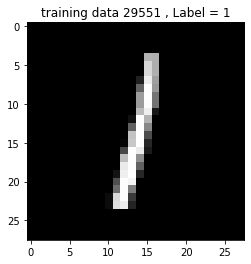

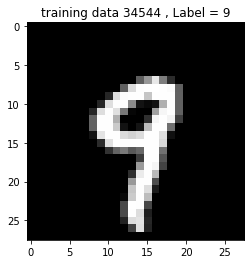

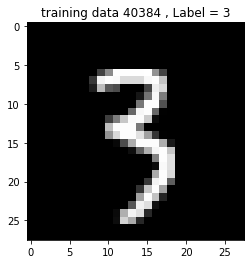

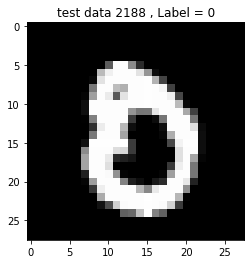

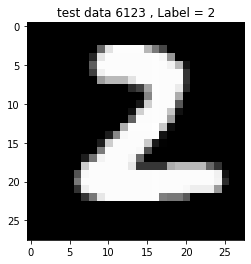

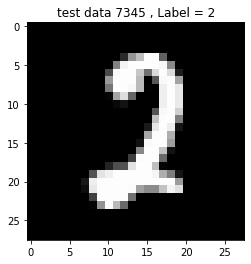

In [3]:
#############################################################################################################
# TODO: randomly select 3 indices for training data and 3 indices for test data,
#       and use matplotlib "imshow" function to plot the the data as figure.
#       The training images are in the numpy array "mnist_trainX", the training labels are in the numpy array "mnist_trainY"
#       The test     images are in the numpy array "mnist_testX" , the test     labels are in the numpy array "mnist_testY"
# Hint: we have flattened the images, so you may have to convert them back to plot the images.
#############################################################################################################

############################################################### TODO A
idx = np.sort(np.random.choice(mnist_trainX.shape[0], 3))
for i in idx:
    plt.imshow(mnist_trainX[i].reshape(28, 28), cmap='gray')
    plt.title('training data {} , Label = {}'.format(i, mnist_trainY[i]))
    plt.show()
    
idx = np.sort(np.random.choice(mnist_testX.shape[0], 3))
for i in idx:
    plt.imshow(mnist_testX[i].reshape(28, 28), cmap='gray')
    plt.title('test data {} , Label = {}'.format(i, mnist_testY[i]))
    plt.show()
############################################################### TODO A

In the cell below, split the validation set with fraction 0.2

### (b) Split training set and the validation set

Split training set and the validation set.

First, you should get 20\% of the "mnist_trainX" as our data, because we just want to use a subset of the original training set.
Then, split 80\% of the data to be our training data, and the remaining 20\% as our validation data.

In [4]:
#############################################################################################################
# Please Fill in the cell to implement X_train, Y_train, X_valid, Y_valid in numpy array
# Also provide the number of data in n_valid, and n_test
# The raw data is loaded in the numpy arrays "mnist_trainX" and "mnist_trainY"
#     Definition of the required variable:
#          X_train: the training images
#          Y_train: the training labels
#          X_valid: the validation images
#          Y_train: the validation labels
#          n_train: the number of training data
#          n_valid: the number of validation data
#############################################################################################################

# the split fraction
train_frac = 0.2
valid_frac = 0.2

############################################# TODO B
n_train = int(np.ceil(mnist_trainX.shape[0] * train_frac * (1 - valid_frac)))
n_valid = int(np.ceil(mnist_trainX.shape[0] * train_frac * valid_frac))

mnist_subsetX = mnist_trainX[:n_train+n_valid]
mnist_subsetY = mnist_trainY[:n_train+n_valid]

X_train = mnist_subsetX[:n_train]
Y_train = mnist_subsetY[:n_train]

X_valid = mnist_subsetX[n_train:]
Y_valid = mnist_subsetY[n_train:]
#############################################
# renaming the test data
X_test = mnist_testX
Y_test = mnist_testY
n_test = mnist_testX.shape[0]
# Turn the numpy array to pytorch tensor
X_train = torch.Tensor(X_train)
Y_train = torch.from_numpy(Y_train)

X_valid = torch.Tensor(X_valid)
Y_valid = torch.from_numpy(Y_valid)

X_test = torch.Tensor(X_test)
Y_test = torch.from_numpy(Y_test)

print("Number of training data: {}".format(n_train))
print("Number of validation data: {}".format(n_valid))
print("Number of test data: {}".format(n_test))

Number of training data: 9600
Number of validation data: 2400
Number of test data: 10000


### **(c) Implementing activation functions: Mish and Swish**
Pytorch provides many activation units under torch.nn.Module.

We can just use torch.nn.{Module Name} to instantiates the module. [Here is the reference of the official documentation on the types of activation functions and how to use them](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

Moreover, we can also define new activation units.

In this problem, we will implement Mish and Swish activation function

The original paper for Mish : https://arxiv.org/abs/1908.08681

The original paper for Swish: https://arxiv.org/abs/1710.05941

The Mish function is defined as:

$f_{Mish}(x) = x(tanh(ln(1+e^x)))$

And the Swish function is defined as: 

$f_{Swish}(x) = x(sigmoid(\beta x)) = \frac{x}{( 1 + e^{\beta x})}$, where $\beta$ is a learnable weight 

Implement the two function by completing forward and backward(gradient) method.
You can use torch.gradcheck to see if your gradient is computed correctly. The torch.gradcheck compares the analytical gradients to numerical gradients, in which the analytical gradients are obtained by the backward methods and the numerical gradients are obtained by introducing small difference to the input.

If your implementation is corrent. The gradcheck function will return True.
For more implemenation details, you can see the official note from pytorch: https://pytorch.org/docs/stable/notes/extending.html

In [27]:
# This is an example of how to implement an autograd function in pytorch
# the forward function compute the output of the function 
# the backward function computes the gradient with respect to the input (and other parameters like weights)
# For activation function, this can be easily done by chain rule.
# As the example, the gradient w.r.t input equals the gradient w.r.t its output multiplied 
#    by the gradient of its output w.r.t its input 
# The ctx.saved_tensors can save the input and some tempory results from forward method
# In the backward method, call ctx.saved_tensors to load the input and tempory results
class SigmoidFunction(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x):
        output = 1.0/ ( 1 + torch.exp(-x))
        ctx.save_for_backward(output)   # save for backward function
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        output, = ctx.saved_tensors
        grad_input = output * (1 - output) * grad_output
        return grad_input

class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ##########################################################################################
        # TODO: implement the forward function for mish
        #       You should compute the intermediate result of the tanh function and the output:
        #       Input: 
        #           x: the input variable to the function
        #       Variable to implement:
        #           tanh_ : compute the tanh( ln (1+e^x) )
        #           output: the output of the mish function, using the intermediate result tanh_
        # Hint: using functions provided by pytorch: torch.tanh, torch.log, and torch.exp
        #       We will use the intermediate result to reduce computation loads for the backward function
        ##########################################################################################
        ################################################### TODO C_1
        tanh_ = torch.tanh(torch.log(1+torch.exp(x)))
        output = x* tanh_ 
        ###################################################
        ctx.save_for_backward(x, tanh_)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        x, tanh_ = ctx.saved_tensors
        ##########################################################################################
        # TODO: implement the backward function for mish
        #       The original input x and the intermediate result tanh_ is available.
        #       You should compute gradient with w.r.t the input of the mish :
        #       Input: 
        #           grad_output : the gradient of the loss function w.r.t the "output" of the mish function
        #       Variable to implement:
        #           grad_input  : the gradient of the loss function w.r.t the "input" of the mish :
        # Hint: using functions provided by pytorch: torch.exp, and using the intermediate result tanh_
        ##########################################################################################
        ################################################### TODO C_2
        grad_input = (tanh_ + x * (1 - tanh_*tanh_) / (1 + torch.exp(-x))) * grad_output
        ###################################################
        return grad_input    
    
class SwishFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, beta):
        ##########################################################################################
        # TODO: implement the forward function for swish
        #       You should compute the intermediate result of the swish function and the output:
        #       Input: 
        #           x: the input variable to the function
        #       beta:  the learnable parameter of the swish
        #       Variable to implement:
        #           beta_sigmoid : compute the sigmoid(beta*x)
        #           output: the output of the swish function, using the intermediate result beta_sigmoid
        # Hint: using functions provided by pytorch: torch.exp or torch.sigmoid
        #       We will use the intermediate result to reduce computation loads for the backward function
        ##########################################################################################
        ################################################### TODO C_3
        beta_sigmoid = 1 / ( 1 + torch.exp(-beta * x))
        output = x * beta_sigmoid
        ################################################### 
        ctx.save_for_backward(x, beta, beta_sigmoid)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # The beta in swish function is learnable. Therefore you have to also compute the gradients w.r.t beta
        x, beta, beta_sigmoid = ctx.saved_tensors
        ##########################################################################################
        # TODO: implement the backward function for swish
        #       The original input x, learnable parameter beta and the intermediate result beta_sigmoid is available.
        #       You should compute gradient with w.r.t the input and the learnable parameter of the mish :
        #       Input: 
        #           grad_output : the gradient of the loss function w.r.t the "output" of the swish function
        #       Variable to implement:
        #           grad_input  : the gradient of the loss function w.r.t the "input" of the swish :
        #           grad_beta   : the gradient of the loss function w.r.t the parameter beta:
        ##########################################################################################
        ################################################### TODO C_4
        grad_input = (beta_sigmoid + x * beta_sigmoid * (1-beta_sigmoid) * beta) * grad_output
        grad_beta =  x * beta_sigmoid * (1-beta_sigmoid) * x * grad_output
        ################################################### TODO
        return grad_input, grad_beta
    
sigmoid = SigmoidFunction.apply
mish = MishFunction.apply
swish = SwishFunction.apply


class Sigmoid(torch.nn.Module):
    
    def __init__(self):
        super(MySigmoid, self).__init__()

    def forward(self, input):
        return sigmoid(input)

class Mish(torch.nn.Module):
    
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, input):
        return mish(input)
    
class Swish(torch.nn.Module):
    
    def __init__(self):
        super(Swish, self).__init__()
        self.beta = torch.nn.Parameter(torch.Tensor(1))
        self.beta.data.uniform_(-0.1, 0.1)
        
    def forward(self, input):
        return swish(input, self.beta)

input = (torch.randn(50,50,dtype=torch.double,requires_grad=True))
test_result = gradcheck(sigmoid, input, eps=1e-6, atol=1e-4)
print("Gradient check for sigmoid function: ", test_result)
input = (torch.randn(50,50,dtype=torch.double,requires_grad=True))
test_result = gradcheck(mish, input, eps=1e-6, atol=1e-4)
print("Gradient check for mish function: ", test_result)
input = (torch.randn(50,50,dtype=torch.double,requires_grad=True), torch.randn(50,50,dtype=torch.double,requires_grad=True))
test_result = gradcheck(swish, input, eps=1e-6, atol=1e-4)
print("Gradient check for swish function: ", test_result)

Gradient check for sigmoid function:  True
Gradient check for mish function:  True
Gradient check for swish function:  True


### (d) Training neural networks using different activation function



In [6]:
D_in = mnist_trainX.shape[1]
D_out = 10

def training(activation_module, D_hidden_in, D_hidden_out, x, y, learning_rate, epochs):
    
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, D_hidden_in),
        activation_module(),
        torch.nn.Linear(D_hidden_in, D_hidden_out),
        activation_module(),
        torch.nn.Linear(D_hidden_out, D_out),
    )
    
    loss_train_his = []
    loss_valid_his = []
    acc_train_his = []
    acc_valid_his = []

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    for i in range(epochs):
        
        if i%10 == 9:
            with torch.no_grad():
                model.eval()
                loss_valid, acc_valid = test(model, X_valid, Y_valid)
                loss_valid_his.append(loss_valid)
                acc_valid_his.append(acc_valid)
                loss_train, acc_train = test(model, x, y)
                loss_train_his.append(loss_train)
                acc_train_his.append(acc_train)
                print(i, "loss = ", loss_train, "acc = ", acc_train, "valid: ", (loss_valid, acc_valid))
        model.train()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Training complete")
    return model, loss_train_his, loss_valid_his, acc_train_his, acc_valid_his

def test(model, X_test, Y_test):
    
    y_pred = model(X_test)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(y_pred, Y_test)
    _, label = torch.max(y_pred, 1)
    return loss.item(), (torch.count_nonzero(label == Y_test)/ Y_test.shape[0]).item()


Using the above training function, train the classifier using different activation function including ReLU, Sigmoid, LeakyReLU, and Tanh, Swish, and Mish.

Record the returned losses and accuracy in the array losses and accs.

First, using the same learning rate 0.005 for all activation function

In [7]:
epochs = 1000
learning_rate = 5e-3
activation_units = [torch.nn.ReLU, torch.nn.Sigmoid, torch.nn.LeakyReLU, torch.nn.Tanh, Mish, Swish]
activation_strs = ["ReLU", "Sigmoid", "LeakyReLU", "Tanh",  "Mish", "Swish"]
learning_rate = [5e-3, 5e-3, 5e-3, 5e-3, 5e-3, 5e-3]
models = []
losses = np.zeros((len(activation_units), 2, int(epochs/10)))
accs = np.zeros((len(activation_units), 2, int(epochs/10)))


for i, act in enumerate(activation_units):
    print("Training with {} activation units".format(activation_strs[i]))
# Call the training function to get the model, loss and accuracy
    model, loss_train_his, loss_valid_his, acc_train_his, acc_valid_his = training(act, 
                200, 64, X_train, Y_train, learning_rate[i], epochs)
    models.append(model)
    losses[i,0,:] = np.array(loss_train_his)
    losses[i,1,:] = np.array(loss_valid_his)
    accs[i,0,:] = np.array(acc_train_his)
    accs[i,1,:] = np.array(acc_valid_his)

Training with ReLU activation units
9 loss =  1.6379268169403076 acc =  0.4833333194255829 valid:  (1.6991046667099, 0.46666666865348816)
19 loss =  0.7683355212211609 acc =  0.7621874809265137 valid:  (0.8067874908447266, 0.7408333420753479)
29 loss =  0.5607649683952332 acc =  0.8307291865348816 valid:  (0.6104511022567749, 0.815833330154419)
39 loss =  0.455530047416687 acc =  0.863854169845581 valid:  (0.5165022611618042, 0.8483333587646484)
49 loss =  0.39228466153144836 acc =  0.8821874856948853 valid:  (0.45926499366760254, 0.8700000047683716)
59 loss =  0.34829267859458923 acc =  0.8967708349227905 valid:  (0.41930022835731506, 0.877916693687439)
69 loss =  0.3148201107978821 acc =  0.9053124785423279 valid:  (0.38955816626548767, 0.8866666555404663)
79 loss =  0.2878592908382416 acc =  0.9147916436195374 valid:  (0.36646443605422974, 0.8924999833106995)
89 loss =  0.2656470239162445 acc =  0.9226041436195374 valid:  (0.3482820987701416, 0.9008333086967468)
99 loss =  0.2469316

769 loss =  0.023194797337055206 acc =  0.9978125095367432 valid:  (0.21304820477962494, 0.9420833587646484)
779 loss =  0.022665128111839294 acc =  0.9978125095367432 valid:  (0.21309877932071686, 0.9424999952316284)
789 loss =  0.02214926853775978 acc =  0.9979166388511658 valid:  (0.21311551332473755, 0.9424999952316284)
799 loss =  0.02165021002292633 acc =  0.9979166388511658 valid:  (0.21321217715740204, 0.9424999952316284)
809 loss =  0.021168302744627 acc =  0.9981250166893005 valid:  (0.21326953172683716, 0.9429166913032532)
819 loss =  0.020700441673398018 acc =  0.9981250166893005 valid:  (0.21331124007701874, 0.9433333277702332)
829 loss =  0.02025105059146881 acc =  0.9984375238418579 valid:  (0.21342028677463531, 0.9433333277702332)
839 loss =  0.01981639489531517 acc =  0.9984375238418579 valid:  (0.21352483332157135, 0.9437500238418579)
849 loss =  0.019394921138882637 acc =  0.9985416531562805 valid:  (0.2136184126138687, 0.9433333277702332)
859 loss =  0.0189848951995

529 loss =  2.132416009902954 acc =  0.5410416722297668 valid:  (2.1319000720977783, 0.5416666865348816)
539 loss =  2.1290290355682373 acc =  0.5448958277702332 valid:  (2.1285672187805176, 0.5475000143051147)
549 loss =  2.1256263256073 acc =  0.5491666793823242 valid:  (2.125196695327759, 0.5512499809265137)
559 loss =  2.1221938133239746 acc =  0.5528125166893005 valid:  (2.1218132972717285, 0.5541666746139526)
569 loss =  2.118718385696411 acc =  0.5555208325386047 valid:  (2.1184160709381104, 0.559583306312561)
579 loss =  2.1152095794677734 acc =  0.5587499737739563 valid:  (2.114971160888672, 0.565833330154419)
589 loss =  2.11167311668396 acc =  0.5611458420753479 valid:  (2.1114766597747803, 0.5699999928474426)
599 loss =  2.1081337928771973 acc =  0.5638541579246521 valid:  (2.1079585552215576, 0.5741666555404663)
609 loss =  2.104567289352417 acc =  0.5666666626930237 valid:  (2.104422092437744, 0.5787500143051147)
619 loss =  2.1009747982025146 acc =  0.5697916746139526 va

299 loss =  0.10595519095659256 acc =  0.9746875166893005 valid:  (0.24650533497333527, 0.9279166460037231)
309 loss =  0.10231787711381912 acc =  0.9760416746139526 valid:  (0.24475334584712982, 0.9279166460037231)
319 loss =  0.09887660294771194 acc =  0.9773958325386047 valid:  (0.24317996203899384, 0.9279166460037231)
329 loss =  0.09558548778295517 acc =  0.9781249761581421 valid:  (0.24162836372852325, 0.9287499785423279)
339 loss =  0.0924411192536354 acc =  0.9789583086967468 valid:  (0.24013608694076538, 0.9287499785423279)
349 loss =  0.08944421261548996 acc =  0.9797916412353516 valid:  (0.23863710463047028, 0.9291666746139526)
359 loss =  0.08657597005367279 acc =  0.9805208444595337 valid:  (0.23731930553913116, 0.9291666746139526)
369 loss =  0.08382842689752579 acc =  0.981249988079071 valid:  (0.23614013195037842, 0.9295833110809326)
379 loss =  0.08119388669729233 acc =  0.9817708134651184 valid:  (0.2349807769060135, 0.9304166436195374)
389 loss =  0.0786726325750351 

59 loss =  1.7750970125198364 acc =  0.6945833563804626 valid:  (1.774549126625061, 0.6879166960716248)
69 loss =  1.7116914987564087 acc =  0.7204166650772095 valid:  (1.7108848094940186, 0.7162500023841858)
79 loss =  1.6521722078323364 acc =  0.7418749928474426 valid:  (1.6501232385635376, 0.7366666793823242)
89 loss =  1.5965855121612549 acc =  0.7567708492279053 valid:  (1.595687985420227, 0.7504166960716248)
99 loss =  1.5452544689178467 acc =  0.7668750286102295 valid:  (1.5463534593582153, 0.762499988079071)
109 loss =  1.4962588548660278 acc =  0.7769791483879089 valid:  (1.4995641708374023, 0.7666666507720947)
119 loss =  1.4489673376083374 acc =  0.785937488079071 valid:  (1.454602837562561, 0.777916669845581)
129 loss =  1.404985785484314 acc =  0.7945833206176758 valid:  (1.4118705987930298, 0.784583330154419)
139 loss =  1.3629289865493774 acc =  0.801770806312561 valid:  (1.3713016510009766, 0.7904166579246521)
149 loss =  1.323306918144226 acc =  0.8083333373069763 vali

829 loss =  0.41310909390449524 acc =  0.9284374713897705 valid:  (0.5029097199440002, 0.887499988079071)
839 loss =  0.4091857671737671 acc =  0.9288541674613953 valid:  (0.4997481405735016, 0.887499988079071)
849 loss =  0.4055987596511841 acc =  0.92947918176651 valid:  (0.496722012758255, 0.8879166841506958)
859 loss =  0.40180733799934387 acc =  0.92989581823349 valid:  (0.49369120597839355, 0.8879166841506958)
869 loss =  0.3980119526386261 acc =  0.9304166436195374 valid:  (0.4909358620643616, 0.8883333206176758)
879 loss =  0.39443278312683105 acc =  0.9311458468437195 valid:  (0.48819178342819214, 0.8887500166893005)
889 loss =  0.3909575045108795 acc =  0.9310416579246521 valid:  (0.48541876673698425, 0.8887500166893005)
899 loss =  0.38755667209625244 acc =  0.9310416579246521 valid:  (0.4826454222202301, 0.8891666531562805)
909 loss =  0.384304940700531 acc =  0.9315624833106995 valid:  (0.4798586666584015, 0.8899999856948853)
919 loss =  0.38107427954673767 acc =  0.932083

589 loss =  0.0492563471198082 acc =  0.9917708039283752 valid:  (0.23815396428108215, 0.9325000047683716)
599 loss =  0.048049960285425186 acc =  0.9921875 valid:  (0.2378317266702652, 0.9320833086967468)
609 loss =  0.04687710106372833 acc =  0.9922916889190674 valid:  (0.2375335991382599, 0.9320833086967468)
619 loss =  0.045736972242593765 acc =  0.9926041960716248 valid:  (0.23726855218410492, 0.9325000047683716)
629 loss =  0.044630248099565506 acc =  0.9929166436195374 valid:  (0.2370317578315735, 0.9329166412353516)
639 loss =  0.04355746507644653 acc =  0.9929166436195374 valid:  (0.23682288825511932, 0.9333333373069763)
649 loss =  0.04251804202795029 acc =  0.9934375286102295 valid:  (0.2366388738155365, 0.9337499737739563)
659 loss =  0.0415116585791111 acc =  0.9938541650772095 valid:  (0.23647503554821014, 0.934166669845581)
669 loss =  0.04053667187690735 acc =  0.9940624833106995 valid:  (0.23632626235485077, 0.934583306312561)
679 loss =  0.03959137201309204 acc =  0.9

349 loss =  0.16960963606834412 acc =  0.9511458277702332 valid:  (0.3503185510635376, 0.909583330154419)
359 loss =  0.15988631546497345 acc =  0.9547916650772095 valid:  (0.3408978283405304, 0.9083333611488342)
369 loss =  0.15862807631492615 acc =  0.9547916650772095 valid:  (0.3386271595954895, 0.9087499976158142)
379 loss =  0.18344970047473907 acc =  0.9456250071525574 valid:  (0.35148322582244873, 0.90625)
389 loss =  0.15130861103534698 acc =  0.9571874737739563 valid:  (0.3376898467540741, 0.9100000262260437)
399 loss =  0.1478303074836731 acc =  0.9584375023841858 valid:  (0.3382008373737335, 0.9133333563804626)
409 loss =  0.14681528508663177 acc =  0.9589583277702332 valid:  (0.3385898470878601, 0.9137499928474426)
419 loss =  0.14208227396011353 acc =  0.9605208039283752 valid:  (0.33607950806617737, 0.9150000214576721)
429 loss =  0.13785336911678314 acc =  0.9618750214576721 valid:  (0.3347773849964142, 0.9154166579246521)
439 loss =  0.13503418862819672 acc =  0.9633333

Visualize the change of loss and accuracy versus epochs.

You should have four plots (1) training loss (2) validation loss (3) training accuracy (4) validation accuracy

Observe the loss and accuracy.

**_Your Observation:_**

We can see that the ReLU, LeakyReLU and Mish have similar loss during training, and their loss have converged. Their performance are the best compared with other activation functions.  For Tanh and Sigmoid activation units, the loss do decrease but have not converged, which indicate that we should slightly increase the learning rate or increase the number of epochs. For  Swish activation unit, The model might not converged. If that happens, the loss does not decrease and the accuracy remains low as that of random guess. This means either the model parameter is unsuitable for this activation function. Actually this is affected by the initialization. You can try using another way of random initialization to see what will change or just proceed with the remaining questions.

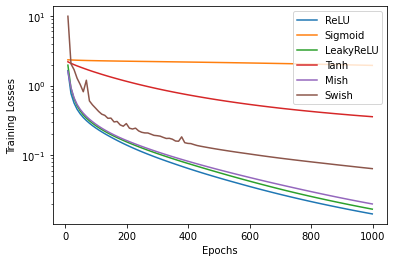

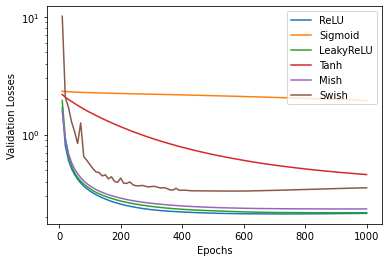

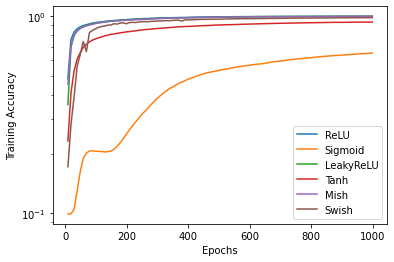

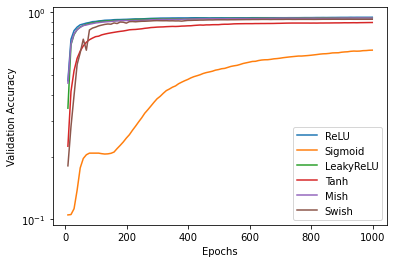

In [8]:
x_range = range(9, epochs, 10)
for i, act in enumerate(activation_units):
    plt.plot(x_range, losses[i,0], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Training Losses")
plt.yscale("log")
plt.legend()
plt.show()

for i, act in enumerate(activation_units):
    plt.plot(x_range, losses[i,1], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Validation Losses")
plt.yscale("log")
plt.legend()
plt.show()

for i, act in enumerate(activation_units):
    plt.plot(x_range, accs[i,0], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.yscale("log")
plt.legend()
plt.show()

for i, act in enumerate(activation_units):
    plt.plot(x_range, accs[i,1], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.yscale("log")
plt.legend()
plt.show()

### **(e) Grid search of learning rate for different activation functions**
You should have noticed that some activation units did not converge.

This means that the learning rate may be too low for those activation units.

Adjust the learning rates for those activation units, and try to optimize the learning rate for each activation unit.

In [9]:
num_lr = 8
epochs = 1000
losses = np.zeros((len(activation_units), 2, num_lr, int(epochs/10)))
accs = np.zeros((len(activation_units), 2, num_lr, int(epochs/10)))
#############################################################################################################
# TODO: set the learning_rates array so that we can search through different learning rates for each activation functions
# Example: by setting learning_rates = [0.1, 0.2]*len(activation_units), the below code will train
#          using learning rates 0.1 and 0.2 for each activation function neural network. 
#############################################################################################################

###################################################### TODO E
learning_rates = [np.logspace(-3.0, 0.0, num=num_lr)]*len(activation_units)
######################################################
for i, act in enumerate(activation_units):
    for j, lr in enumerate(learning_rates[i]):
        print("Training with {} activation units at learning rate {}".format(activation_strs[i], lr))

    # Call the training function to get the model, loss and accuracy
        model, loss_train_his, loss_valid_his, acc_train_his, acc_valid_his = training(act, 
                    200, 64, X_train, Y_train, lr, epochs)
        models.append(model)
        losses[i,0,j,:] = np.array(loss_train_his)
        losses[i,1,j,:] = np.array(loss_valid_his)
        accs[i,0,j,:] = np.array(acc_train_his)
        accs[i,1,j,:] = np.array(acc_valid_his)

Training with ReLU activation units at learning rate 0.001
9 loss =  1.7455973625183105 acc =  0.5482291579246521 valid:  (1.677695393562317, 0.5766666531562805)
19 loss =  1.190940022468567 acc =  0.668541669845581 valid:  (1.1724430322647095, 0.6825000047683716)
29 loss =  0.9489172101020813 acc =  0.7288541793823242 valid:  (0.9609270095825195, 0.7391666769981384)
39 loss =  0.8062681555747986 acc =  0.7673958539962769 valid:  (0.8378711938858032, 0.7649999856948853)
49 loss =  0.7106577157974243 acc =  0.7945833206176758 valid:  (0.7550466656684875, 0.784583330154419)
59 loss =  0.6406888365745544 acc =  0.8108333349227905 valid:  (0.6952866911888123, 0.8012499809265137)
69 loss =  0.586533784866333 acc =  0.8263541460037231 valid:  (0.648768961429596, 0.8141666650772095)
79 loss =  0.5428731441497803 acc =  0.8403124809265137 valid:  (0.6114605069160461, 0.8224999904632568)
89 loss =  0.5069082379341125 acc =  0.8507291674613953 valid:  (0.5807293057441711, 0.8291666507720947)
99 

769 loss =  0.10787998139858246 acc =  0.9750000238418579 valid:  (0.2919560372829437, 0.9108333587646484)
779 loss =  0.10639027506113052 acc =  0.9754166603088379 valid:  (0.2912869155406952, 0.9100000262260437)
789 loss =  0.10493267327547073 acc =  0.9755208492279053 valid:  (0.29068800806999207, 0.9104166626930237)
799 loss =  0.10350636392831802 acc =  0.9755208492279053 valid:  (0.29004359245300293, 0.9104166626930237)
809 loss =  0.1021108478307724 acc =  0.9761458039283752 valid:  (0.2894255518913269, 0.9116666913032532)
819 loss =  0.10074453800916672 acc =  0.9765625 valid:  (0.2888075113296509, 0.9116666913032532)
829 loss =  0.09940781444311142 acc =  0.97677081823349 valid:  (0.28820979595184326, 0.9116666913032532)
839 loss =  0.09809665381908417 acc =  0.9771875143051147 valid:  (0.28761374950408936, 0.9116666913032532)
849 loss =  0.09680183231830597 acc =  0.9777083396911621 valid:  (0.28707101941108704, 0.9116666913032532)
859 loss =  0.09553366154432297 acc =  0.978

519 loss =  0.06523577123880386 acc =  0.9871875047683716 valid:  (0.2686135768890381, 0.9270833134651184)
529 loss =  0.06362804770469666 acc =  0.9876041412353516 valid:  (0.267930805683136, 0.9275000095367432)
539 loss =  0.06207478046417236 acc =  0.9882291555404663 valid:  (0.26721853017807007, 0.9291666746139526)
549 loss =  0.06057089939713478 acc =  0.988854169845581 valid:  (0.26652991771698, 0.9300000071525574)
559 loss =  0.05912097170948982 acc =  0.989270806312561 valid:  (0.2659529447555542, 0.9316666722297668)
569 loss =  0.05771607160568237 acc =  0.9895833134651184 valid:  (0.26535338163375854, 0.9316666722297668)
579 loss =  0.05635733902454376 acc =  0.9897916913032532 valid:  (0.2647792100906372, 0.9325000047683716)
589 loss =  0.05504297837615013 acc =  0.9900000095367432 valid:  (0.26418644189834595, 0.9329166412353516)
599 loss =  0.053765296936035156 acc =  0.9903125166893005 valid:  (0.2636512219905853, 0.9325000047683716)
609 loss =  0.05251917988061905 acc = 

279 loss =  0.13034261763095856 acc =  0.965833306312561 valid:  (0.2606840431690216, 0.9254166483879089)
289 loss =  0.12611785531044006 acc =  0.9664583206176758 valid:  (0.25877514481544495, 0.9270833134651184)
299 loss =  0.12212733179330826 acc =  0.9679166674613953 valid:  (0.25714191794395447, 0.9275000095367432)
309 loss =  0.1183210015296936 acc =  0.9691666960716248 valid:  (0.25564029812812805, 0.9275000095367432)
319 loss =  0.11464256048202515 acc =  0.9702083468437195 valid:  (0.25422051548957825, 0.9283333420753479)
329 loss =  0.11106151342391968 acc =  0.9711458086967468 valid:  (0.2532719671726227, 0.9287499785423279)
339 loss =  0.10766491293907166 acc =  0.971875011920929 valid:  (0.2518758475780487, 0.9291666746139526)
349 loss =  0.10434556007385254 acc =  0.9731249809265137 valid:  (0.25107133388519287, 0.9295833110809326)
359 loss =  0.10132645070552826 acc =  0.9740625023841858 valid:  (0.24988749623298645, 0.9300000071525574)
369 loss =  0.09815317392349243 ac

29 loss =  2.275177240371704 acc =  0.12687499821186066 valid:  (2.30641770362854, 0.12291666865348816)
39 loss =  2.2986161708831787 acc =  0.11041666567325592 valid:  (2.3163833618164062, 0.10999999940395355)
49 loss =  2.2970354557037354 acc =  0.11114583164453506 valid:  (2.3145148754119873, 0.11083333194255829)
59 loss =  2.271972179412842 acc =  0.12708333134651184 valid:  (2.2981960773468018, 0.125)
69 loss =  2.2944188117980957 acc =  0.11385416984558105 valid:  (2.3116602897644043, 0.1120833307504654)
79 loss =  2.2890729904174805 acc =  0.11625000089406967 valid:  (2.309924840927124, 0.11500000208616257)
89 loss =  2.2872872352600098 acc =  0.1171875 valid:  (2.3009204864501953, 0.11541666835546494)
99 loss =  2.2467384338378906 acc =  0.14927083253860474 valid:  (2.2736427783966064, 0.1445833295583725)
109 loss =  2.2377359867095947 acc =  0.22822916507720947 valid:  (2.2240052223205566, 0.23499999940395355)
119 loss =  2.2978627681732178 acc =  0.11239583045244217 valid:  (

799 loss =  2.2979438304901123 acc =  0.11083333194255829 valid:  (2.30660343170166, 0.10999999940395355)
809 loss =  2.2978646755218506 acc =  0.11083333194255829 valid:  (2.306602954864502, 0.10999999940395355)
819 loss =  2.2979037761688232 acc =  0.11083333194255829 valid:  (2.3066024780273438, 0.10999999940395355)
829 loss =  2.2977588176727295 acc =  0.11093749850988388 valid:  (2.306391716003418, 0.10999999940395355)
839 loss =  2.2959325313568115 acc =  0.11229166388511658 valid:  (2.30265736579895, 0.11249999701976776)
849 loss =  2.293809413909912 acc =  0.1132291629910469 valid:  (2.3026325702667236, 0.11291666328907013)
859 loss =  2.2885236740112305 acc =  0.11677083373069763 valid:  (2.2971365451812744, 0.11791666597127914)
869 loss =  2.259506940841675 acc =  0.13458333909511566 valid:  (2.295881986618042, 0.13333334028720856)
879 loss =  2.2959420680999756 acc =  0.11218749731779099 valid:  (2.303781509399414, 0.1120833307504654)
889 loss =  2.203683853149414 acc =  0.1

559 loss =  2.300185441970825 acc =  0.1133333370089531 valid:  (2.301666021347046, 0.10958333313465118)
569 loss =  2.300224781036377 acc =  0.1133333370089531 valid:  (2.3016767501831055, 0.10958333313465118)
579 loss =  2.3002665042877197 acc =  0.1133333370089531 valid:  (2.3016586303710938, 0.10958333313465118)
589 loss =  2.300253391265869 acc =  0.1133333370089531 valid:  (2.301649808883667, 0.10958333313465118)
599 loss =  2.3002068996429443 acc =  0.1133333370089531 valid:  (2.3016715049743652, 0.10958333313465118)
609 loss =  2.300321340560913 acc =  0.1133333370089531 valid:  (2.3016669750213623, 0.10958333313465118)
619 loss =  2.3003110885620117 acc =  0.1133333370089531 valid:  (2.301669120788574, 0.10958333313465118)
629 loss =  2.3003170490264893 acc =  0.1133333370089531 valid:  (2.30168080329895, 0.10958333313465118)
639 loss =  2.3002805709838867 acc =  0.1133333370089531 valid:  (2.301661491394043, 0.10958333313465118)
649 loss =  2.3002102375030518 acc =  0.1133333

319 loss =  2.3002893924713135 acc =  0.1133333370089531 valid:  (2.718796491622925, 0.10958333313465118)
329 loss =  2.300333023071289 acc =  0.1133333370089531 valid:  (2.7187907695770264, 0.10958333313465118)
339 loss =  2.300311803817749 acc =  0.1133333370089531 valid:  (2.7188024520874023, 0.10958333313465118)
349 loss =  2.3002824783325195 acc =  0.1133333370089531 valid:  (2.718815565109253, 0.10958333313465118)
359 loss =  2.3003060817718506 acc =  0.1133333370089531 valid:  (2.71877384185791, 0.10958333313465118)
369 loss =  2.3002655506134033 acc =  0.1133333370089531 valid:  (2.7187743186950684, 0.10958333313465118)
379 loss =  2.300227165222168 acc =  0.1133333370089531 valid:  (2.7188146114349365, 0.10958333313465118)
389 loss =  2.300271511077881 acc =  0.1133333370089531 valid:  (2.7188334465026855, 0.10958333313465118)
399 loss =  2.3002126216888428 acc =  0.1133333370089531 valid:  (2.7188150882720947, 0.10958333313465118)
409 loss =  2.300177812576294 acc =  0.113333

79 loss =  2.3006479740142822 acc =  0.1133333370089531 valid:  (2.3021609783172607, 0.10958333313465118)
89 loss =  2.3004584312438965 acc =  0.1133333370089531 valid:  (2.3019227981567383, 0.10958333313465118)
99 loss =  2.3004045486450195 acc =  0.1133333370089531 valid:  (2.301795244216919, 0.10958333313465118)
109 loss =  2.3003480434417725 acc =  0.1133333370089531 valid:  (2.301750898361206, 0.10958333313465118)
119 loss =  2.3002617359161377 acc =  0.1133333370089531 valid:  (2.3017377853393555, 0.10958333313465118)
129 loss =  2.3002779483795166 acc =  0.1133333370089531 valid:  (2.3017003536224365, 0.10958333313465118)
139 loss =  2.300318717956543 acc =  0.1133333370089531 valid:  (2.3017094135284424, 0.10958333313465118)
149 loss =  2.3002851009368896 acc =  0.1133333370089531 valid:  (2.301689863204956, 0.10958333313465118)
159 loss =  2.3002254962921143 acc =  0.1133333370089531 valid:  (2.3017046451568604, 0.10958333313465118)
169 loss =  2.300231456756592 acc =  0.11333

849 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
859 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
869 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
879 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
889 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
899 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
909 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
919 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
929 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
939 loss =  2.3003175258636475 acc =  0.113

609 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
619 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
629 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
639 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
649 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
659 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
669 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
679 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
689 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
699 loss =  2.3003175258636475 acc =  0.113

369 loss =  2.2890939712524414 acc =  0.10010416805744171 valid:  (2.290417194366455, 0.09708333015441895)
379 loss =  2.287980556488037 acc =  0.10041666775941849 valid:  (2.289339542388916, 0.09749999642372131)
389 loss =  2.2868969440460205 acc =  0.10083333402872086 valid:  (2.288283586502075, 0.09749999642372131)
399 loss =  2.2858312129974365 acc =  0.10135416686534882 valid:  (2.287242889404297, 0.09916666895151138)
409 loss =  2.2847888469696045 acc =  0.10270833224058151 valid:  (2.286224603652954, 0.10083333402872086)
419 loss =  2.2837631702423096 acc =  0.10520832985639572 valid:  (2.285219192504883, 0.1029166653752327)
429 loss =  2.2827532291412354 acc =  0.10864583402872086 valid:  (2.284229040145874, 0.1041666641831398)
439 loss =  2.28176212310791 acc =  0.11291666328907013 valid:  (2.28324818611145, 0.10791666805744171)
449 loss =  2.280790328979492 acc =  0.11697916686534882 valid:  (2.282287359237671, 0.11041666567325592)
459 loss =  2.279824733734131 acc =  0.12260

129 loss =  2.29891300201416 acc =  0.1495833396911621 valid:  (2.2993133068084717, 0.1587499976158142)
139 loss =  2.295706272125244 acc =  0.15583333373069763 valid:  (2.296205759048462, 0.16625000536441803)
149 loss =  2.2926807403564453 acc =  0.16093750298023224 valid:  (2.2932796478271484, 0.17416666448116302)
159 loss =  2.289837121963501 acc =  0.16447916626930237 valid:  (2.2905097007751465, 0.1808333396911621)
169 loss =  2.287130117416382 acc =  0.16906249523162842 valid:  (2.2878758907318115, 0.18458333611488342)
179 loss =  2.2845404148101807 acc =  0.17239584028720856 valid:  (2.2853591442108154, 0.1887499988079071)
189 loss =  2.2820544242858887 acc =  0.17604166269302368 valid:  (2.2829430103302, 0.19333332777023315)
199 loss =  2.2796592712402344 acc =  0.1822916716337204 valid:  (2.2806198596954346, 0.2016666680574417)
209 loss =  2.2773404121398926 acc =  0.19604167342185974 valid:  (2.2783796787261963, 0.2133333384990692)
219 loss =  2.275120973587036 acc =  0.21385

899 loss =  2.171220302581787 acc =  0.5086458325386047 valid:  (2.1729352474212646, 0.4866666793823242)
909 loss =  2.169705390930176 acc =  0.5117708444595337 valid:  (2.171424388885498, 0.4883333444595337)
919 loss =  2.1681787967681885 acc =  0.5148958563804626 valid:  (2.1699135303497314, 0.4908333420753479)
929 loss =  2.166654348373413 acc =  0.518750011920929 valid:  (2.1683967113494873, 0.4950000047683716)
939 loss =  2.165132522583008 acc =  0.5217708349227905 valid:  (2.166869878768921, 0.4975000023841858)
949 loss =  2.1635985374450684 acc =  0.5248958468437195 valid:  (2.165344476699829, 0.5016666650772095)
959 loss =  2.1620538234710693 acc =  0.5269791483879089 valid:  (2.1638031005859375, 0.5041666626930237)
969 loss =  2.1605074405670166 acc =  0.5289583206176758 valid:  (2.162248373031616, 0.5070833563804626)
979 loss =  2.1589417457580566 acc =  0.5315625071525574 valid:  (2.160684585571289, 0.5091666579246521)
989 loss =  2.1573562622070312 acc =  0.5348958373069763

669 loss =  1.959445595741272 acc =  0.606041669845581 valid:  (1.9596779346466064, 0.5854166746139526)
679 loss =  1.9528601169586182 acc =  0.6079166531562805 valid:  (1.9531489610671997, 0.5870833396911621)
689 loss =  1.9462502002716064 acc =  0.6089583039283752 valid:  (1.9465574026107788, 0.5883333086967468)
699 loss =  1.9395709037780762 acc =  0.6101041436195374 valid:  (1.9399163722991943, 0.5895833373069763)
709 loss =  1.9328436851501465 acc =  0.6107291579246521 valid:  (1.9331932067871094, 0.5912500023841858)
719 loss =  1.9260927438735962 acc =  0.612500011920929 valid:  (1.9264060258865356, 0.59375)
729 loss =  1.9192936420440674 acc =  0.6133333444595337 valid:  (1.9195798635482788, 0.5945833325386047)
739 loss =  1.9124562740325928 acc =  0.6148958206176758 valid:  (1.9127315282821655, 0.5962499976158142)
749 loss =  1.905565619468689 acc =  0.6163541674613953 valid:  (1.9058284759521484, 0.5983333587646484)
759 loss =  1.898645281791687 acc =  0.6182291507720947 valid

439 loss =  1.5733147859573364 acc =  0.729687511920929 valid:  (1.576328158378601, 0.7108333110809326)
449 loss =  1.5528366565704346 acc =  0.7353125214576721 valid:  (1.5562068223953247, 0.7133333086967468)
459 loss =  1.532415509223938 acc =  0.7396875023841858 valid:  (1.5361993312835693, 0.7200000286102295)
469 loss =  1.5121105909347534 acc =  0.7448958158493042 valid:  (1.516322374343872, 0.7241666913032532)
479 loss =  1.4919465780258179 acc =  0.7492708563804626 valid:  (1.4965460300445557, 0.7295833230018616)
489 loss =  1.4719430208206177 acc =  0.7540624737739563 valid:  (1.4769158363342285, 0.73416668176651)
499 loss =  1.4520690441131592 acc =  0.7590625286102295 valid:  (1.45748770236969, 0.7383333444595337)
509 loss =  1.4323525428771973 acc =  0.7634375095367432 valid:  (1.4383059740066528, 0.7412499785423279)
519 loss =  1.412842869758606 acc =  0.7682291865348816 valid:  (1.4193840026855469, 0.7462499737739563)
529 loss =  1.393568515777588 acc =  0.7722916603088379

209 loss =  1.3671177625656128 acc =  0.7697916626930237 valid:  (1.3763980865478516, 0.7450000047683716)
219 loss =  1.317448377609253 acc =  0.7796875238418579 valid:  (1.3283867835998535, 0.7579166889190674)
229 loss =  1.2692700624465942 acc =  0.7893750071525574 valid:  (1.281972050666809, 0.7691666483879089)
239 loss =  1.2228463888168335 acc =  0.7994791865348816 valid:  (1.2373565435409546, 0.7791666388511658)
249 loss =  1.1782252788543701 acc =  0.808020830154419 valid:  (1.1946204900741577, 0.7858333587646484)
259 loss =  1.1353447437286377 acc =  0.8167708516120911 valid:  (1.1538655757904053, 0.7929166555404663)
269 loss =  1.0941510200500488 acc =  0.8240625262260437 valid:  (1.1146986484527588, 0.800000011920929)
279 loss =  1.0550365447998047 acc =  0.8318750262260437 valid:  (1.0769816637039185, 0.8070833086967468)
289 loss =  1.0168877840042114 acc =  0.8396875262260437 valid:  (1.0409793853759766, 0.8137500286102295)
299 loss =  0.9810206294059753 acc =  0.8462499976

979 loss =  0.2534759044647217 acc =  0.9465625286102295 valid:  (0.354423850774765, 0.9079166650772095)
989 loss =  0.23523949086666107 acc =  0.9527083039283752 valid:  (0.3467146158218384, 0.9054166674613953)
999 loss =  0.2334204912185669 acc =  0.953125 valid:  (0.3461545705795288, 0.9070833325386047)
Training complete
Training with Sigmoid activation units at learning rate 0.13894954943731375
9 loss =  2.2318291664123535 acc =  0.3634375035762787 valid:  (2.234457015991211, 0.34291666746139526)
19 loss =  2.153602361679077 acc =  0.5204166769981384 valid:  (2.15548038482666, 0.5062500238418579)
29 loss =  2.057072877883911 acc =  0.5607291460037231 valid:  (2.05963134765625, 0.5412499904632568)
39 loss =  1.936648964881897 acc =  0.5899999737739563 valid:  (1.9403516054153442, 0.5666666626930237)
49 loss =  1.7950479984283447 acc =  0.6183333396911621 valid:  (1.8009036779403687, 0.5887500047683716)
59 loss =  1.6405525207519531 acc =  0.6470833420753479 valid:  (1.64938807487487

739 loss =  0.11175396293401718 acc =  0.9753124713897705 valid:  (0.2556810975074768, 0.9237499833106995)
749 loss =  0.11032947897911072 acc =  0.9754166603088379 valid:  (0.25546854734420776, 0.9254166483879089)
759 loss =  0.10950198769569397 acc =  0.9754166603088379 valid:  (0.2558344006538391, 0.9245833158493042)
769 loss =  0.10844150185585022 acc =  0.9756249785423279 valid:  (0.255662202835083, 0.925000011920929)
779 loss =  0.10796212404966354 acc =  0.9758333563804626 valid:  (0.25592318177223206, 0.9237499833106995)
789 loss =  0.10707153379917145 acc =  0.9758333563804626 valid:  (0.25525397062301636, 0.9241666793823242)
799 loss =  0.1053222045302391 acc =  0.9758333563804626 valid:  (0.2541694939136505, 0.9266666769981384)
809 loss =  0.10450568050146103 acc =  0.9759374856948853 valid:  (0.25304052233695984, 0.9258333444595337)
819 loss =  0.10386986285448074 acc =  0.9757291674613953 valid:  (0.2533171474933624, 0.9245833158493042)
829 loss =  0.10501542687416077 acc 

499 loss =  0.06702540814876556 acc =  0.9847916960716248 valid:  (0.20927689969539642, 0.9362499713897705)
509 loss =  0.0650911033153534 acc =  0.9850000143051147 valid:  (0.20973631739616394, 0.934583306312561)
519 loss =  0.06577003747224808 acc =  0.9846875071525574 valid:  (0.2092772126197815, 0.9354166388511658)
529 loss =  0.06321422010660172 acc =  0.9853125214576721 valid:  (0.20743632316589355, 0.9358333349227905)
539 loss =  0.062171000987291336 acc =  0.9854166507720947 valid:  (0.2082470953464508, 0.9362499713897705)
549 loss =  0.061765167862176895 acc =  0.9856250286102295 valid:  (0.20828020572662354, 0.9350000023841858)
559 loss =  0.06130091845989227 acc =  0.9855208396911621 valid:  (0.20749743282794952, 0.9358333349227905)
569 loss =  0.059644147753715515 acc =  0.9858333468437195 valid:  (0.20800700783729553, 0.934166669845581)
579 loss =  0.059374529868364334 acc =  0.9858333468437195 valid:  (0.2081214189529419, 0.9358333349227905)
589 loss =  0.0586433932185173

249 loss =  0.0782068744301796 acc =  0.9825000166893005 valid:  (0.2048712819814682, 0.9366666674613953)
259 loss =  0.07437703758478165 acc =  0.9836458563804626 valid:  (0.2051416039466858, 0.9379166960716248)
269 loss =  0.06783535331487656 acc =  0.9848958253860474 valid:  (0.20232520997524261, 0.9387500286102295)
279 loss =  0.06591364741325378 acc =  0.9857291579246521 valid:  (0.20161476731300354, 0.9383333325386047)
289 loss =  0.062322214245796204 acc =  0.9865624904632568 valid:  (0.20119263231754303, 0.9362499713897705)
299 loss =  0.061729591339826584 acc =  0.9861458539962769 valid:  (0.2020009309053421, 0.9366666674613953)
309 loss =  0.0581669807434082 acc =  0.9870833158493042 valid:  (0.20284336805343628, 0.9370833039283752)
319 loss =  0.054715562611818314 acc =  0.9876041412353516 valid:  (0.2003847062587738, 0.9383333325386047)
329 loss =  0.05354743450880051 acc =  0.9882291555404663 valid:  (0.20128996670246124, 0.9375)
339 loss =  0.05154002830386162 acc =  0.98

Training with LeakyReLU activation units at learning rate 0.001
9 loss =  1.7705973386764526 acc =  0.49656251072883606 valid:  (1.753885269165039, 0.4945833384990692)
19 loss =  1.2212506532669067 acc =  0.6299999952316284 valid:  (1.2211321592330933, 0.6262500286102295)
29 loss =  0.9696518182754517 acc =  0.7013541460037231 valid:  (0.9822378754615784, 0.6966666579246521)
39 loss =  0.8169832825660706 acc =  0.7505208253860474 valid:  (0.8378340601921082, 0.7408333420753479)
49 loss =  0.7133826017379761 acc =  0.785937488079071 valid:  (0.7425957322120667, 0.778333306312561)
59 loss =  0.6387192606925964 acc =  0.8068749904632568 valid:  (0.6755887269973755, 0.8025000095367432)
69 loss =  0.5824289917945862 acc =  0.8241666555404663 valid:  (0.6259168386459351, 0.8129166960716248)
79 loss =  0.5376789569854736 acc =  0.8393750190734863 valid:  (0.5878289937973022, 0.8245833516120911)
89 loss =  0.5013501644134521 acc =  0.8509374856948853 valid:  (0.5579904317855835, 0.836250007152

769 loss =  0.11400146782398224 acc =  0.9697916507720947 valid:  (0.29074522852897644, 0.9175000190734863)
779 loss =  0.11259904503822327 acc =  0.9703124761581421 valid:  (0.28994014859199524, 0.9170833230018616)
789 loss =  0.11122021079063416 acc =  0.9706249833106995 valid:  (0.2891272008419037, 0.9170833230018616)
799 loss =  0.10987337678670883 acc =  0.9710416793823242 valid:  (0.2883162796497345, 0.9175000190734863)
809 loss =  0.10855356603860855 acc =  0.971666693687439 valid:  (0.28752750158309937, 0.9175000190734863)
819 loss =  0.1072579100728035 acc =  0.971875011920929 valid:  (0.28674551844596863, 0.9179166555404663)
829 loss =  0.10598692297935486 acc =  0.972083330154419 valid:  (0.2860448956489563, 0.9179166555404663)
839 loss =  0.10474313795566559 acc =  0.9725000262260437 valid:  (0.28533613681793213, 0.918749988079071)
849 loss =  0.10352475196123123 acc =  0.9727083444595337 valid:  (0.28462591767311096, 0.918749988079071)
859 loss =  0.10232844948768616 acc =

529 loss =  0.07921881228685379 acc =  0.9829166531562805 valid:  (0.24340298771858215, 0.9279166460037231)
539 loss =  0.07748305052518845 acc =  0.9833333492279053 valid:  (0.24280379712581635, 0.9275000095367432)
549 loss =  0.07579807937145233 acc =  0.98416668176651 valid:  (0.2421369105577469, 0.9279166460037231)
559 loss =  0.07416766881942749 acc =  0.98458331823349 valid:  (0.24148152768611908, 0.9283333420753479)
569 loss =  0.07258817553520203 acc =  0.9850000143051147 valid:  (0.2408500611782074, 0.9279166460037231)
579 loss =  0.07105515152215958 acc =  0.9854166507720947 valid:  (0.2402699738740921, 0.9283333420753479)
589 loss =  0.06956962496042252 acc =  0.9857291579246521 valid:  (0.2397926300764084, 0.9287499785423279)
599 loss =  0.0681297779083252 acc =  0.9862499833106995 valid:  (0.2392594963312149, 0.9295833110809326)
609 loss =  0.06672398746013641 acc =  0.9870833158493042 valid:  (0.23882746696472168, 0.9300000071525574)
619 loss =  0.06536353379487991 acc = 

279 loss =  0.14567574858665466 acc =  0.9601041674613953 valid:  (0.25236567854881287, 0.9308333396911621)
289 loss =  0.1409454643726349 acc =  0.9613541960716248 valid:  (0.24981684982776642, 0.9325000047683716)
299 loss =  0.1369597613811493 acc =  0.9622916579246521 valid:  (0.2478485107421875, 0.9333333373069763)
309 loss =  0.1329869031906128 acc =  0.9633333086967468 valid:  (0.245893657207489, 0.934166669845581)
319 loss =  0.1293172389268875 acc =  0.964062511920929 valid:  (0.24416527152061462, 0.9350000023841858)
329 loss =  0.12555913627147675 acc =  0.9652083516120911 valid:  (0.24250879883766174, 0.9362499713897705)
339 loss =  0.12237457185983658 acc =  0.9666666388511658 valid:  (0.24100351333618164, 0.9350000023841858)
349 loss =  0.11931005120277405 acc =  0.9676041603088379 valid:  (0.23991765081882477, 0.9358333349227905)
359 loss =  0.11591466516256332 acc =  0.96895831823349 valid:  (0.23877643048763275, 0.9358333349227905)
369 loss =  0.11319156736135483 acc =  

49 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
59 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
69 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
79 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
89 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
99 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
109 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
119 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
129 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
139 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
149 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
159 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
169 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672

89 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
99 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
109 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
119 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
129 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
139 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
149 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
159 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
169 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
179 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
189 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
199 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
209 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.1049999

119 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
129 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
139 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
149 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
159 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
169 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
179 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
189 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
199 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
209 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
219 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
229 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
239 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499

149 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
159 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
169 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
179 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
189 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
199 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
209 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
219 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
229 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
239 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
249 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
259 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
269 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499

189 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
199 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
209 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
219 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
229 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
239 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
249 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
259 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
269 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
279 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
289 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
299 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
309 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499

169 loss =  1.9262433052062988 acc =  0.5251041650772095 valid:  (1.937751293182373, 0.4987500011920929)
179 loss =  1.909644365310669 acc =  0.5378124713897705 valid:  (1.9209632873535156, 0.5083333253860474)
189 loss =  1.8937050104141235 acc =  0.5492708086967468 valid:  (1.904751181602478, 0.5195833444595337)
199 loss =  1.8780704736709595 acc =  0.5600000023841858 valid:  (1.8890541791915894, 0.527916669845581)
209 loss =  1.8628778457641602 acc =  0.5722916722297668 valid:  (1.8737326860427856, 0.5358333587646484)
219 loss =  1.8478940725326538 acc =  0.5824999809265137 valid:  (1.8588346242904663, 0.5420833230018616)
229 loss =  1.833349347114563 acc =  0.5893750190734863 valid:  (1.8443235158920288, 0.5562499761581421)
239 loss =  1.8190394639968872 acc =  0.5979166626930237 valid:  (1.829946517944336, 0.5637500286102295)
249 loss =  1.804687738418579 acc =  0.6055208444595337 valid:  (1.8154993057250977, 0.5724999904632568)
259 loss =  1.7904150485992432 acc =  0.6139583587646

949 loss =  1.1601406335830688 acc =  0.8037499785423279 valid:  (1.179428219795227, 0.7862499952316284)
959 loss =  1.1542534828186035 acc =  0.8055208325386047 valid:  (1.1737709045410156, 0.7866666913032532)
969 loss =  1.148432970046997 acc =  0.8070833086967468 valid:  (1.1681658029556274, 0.7866666913032532)
979 loss =  1.1426769495010376 acc =  0.808020830154419 valid:  (1.1626132726669312, 0.7879166603088379)
989 loss =  1.1369507312774658 acc =  0.809166669845581 valid:  (1.1570953130722046, 0.7895833253860474)
999 loss =  1.1312655210494995 acc =  0.8105208277702332 valid:  (1.151616096496582, 0.7925000190734863)
Training complete
Training with Tanh activation units at learning rate 0.0026826957952797246
9 loss =  2.272202730178833 acc =  0.12020833045244217 valid:  (2.2641799449920654, 0.13583333790302277)
19 loss =  2.2024481296539307 acc =  0.20010416209697723 valid:  (2.1983883380889893, 0.20541666448116302)
29 loss =  2.141491174697876 acc =  0.2892708480358124 valid:  (

709 loss =  0.7441247701644897 acc =  0.8782291412353516 valid:  (0.7893120050430298, 0.8525000214576721)
719 loss =  0.7370274066925049 acc =  0.8791666626930237 valid:  (0.7828646302223206, 0.8537499904632568)
729 loss =  0.7300573587417603 acc =  0.8801041841506958 valid:  (0.7765732407569885, 0.8541666865348816)
739 loss =  0.7232067584991455 acc =  0.8809375166893005 valid:  (0.7703965902328491, 0.8545833230018616)
749 loss =  0.7164958715438843 acc =  0.8820833563804626 valid:  (0.7643499970436096, 0.8550000190734863)
759 loss =  0.7099172472953796 acc =  0.88302081823349 valid:  (0.7584360837936401, 0.8550000190734863)
769 loss =  0.7034629583358765 acc =  0.8842708468437195 valid:  (0.7526751756668091, 0.8554166555404663)
779 loss =  0.6971439123153687 acc =  0.8856250047683716 valid:  (0.747036874294281, 0.8566666841506958)
789 loss =  0.6909080743789673 acc =  0.8867708444595337 valid:  (0.7414978742599487, 0.8575000166893005)
799 loss =  0.6847659349441528 acc =  0.887812495

479 loss =  0.5093109607696533 acc =  0.9094791412353516 valid:  (0.5846831202507019, 0.8725000023841858)
489 loss =  0.5012938976287842 acc =  0.9113541841506958 valid:  (0.577373743057251, 0.875)
499 loss =  0.49313491582870483 acc =  0.9130208492279053 valid:  (0.5707315802574158, 0.8762500286102295)
509 loss =  0.4854571521282196 acc =  0.91427081823349 valid:  (0.5640919208526611, 0.8754166960716248)
519 loss =  0.4781002402305603 acc =  0.9150000214576721 valid:  (0.5574209094047546, 0.8758333325386047)
529 loss =  0.4711143374443054 acc =  0.9155208468437195 valid:  (0.5513249039649963, 0.8762500286102295)
539 loss =  0.46363428235054016 acc =  0.9168750047683716 valid:  (0.5451182723045349, 0.877916693687439)
549 loss =  0.4572668969631195 acc =  0.9175000190734863 valid:  (0.5394904613494873, 0.878333330154419)
559 loss =  0.4503481984138489 acc =  0.918541669845581 valid:  (0.5337966680526733, 0.8787500262260437)
569 loss =  0.44436192512512207 acc =  0.9191666841506958 valid

239 loss =  0.38006964325904846 acc =  0.9336458444595337 valid:  (0.4697895348072052, 0.8941666483879089)
249 loss =  0.3693578839302063 acc =  0.9320833086967468 valid:  (0.45862844586372375, 0.8949999809265137)
259 loss =  0.3559678792953491 acc =  0.9350000023841858 valid:  (0.44892609119415283, 0.8979166746139526)
269 loss =  0.3447107970714569 acc =  0.9367708563804626 valid:  (0.43982723355293274, 0.8983333110809326)
279 loss =  0.33309006690979004 acc =  0.9395833611488342 valid:  (0.4301452040672302, 0.8991666436195374)
289 loss =  0.3246777057647705 acc =  0.9399999976158142 valid:  (0.4235430657863617, 0.8991666436195374)
299 loss =  0.31679579615592957 acc =  0.9422916769981384 valid:  (0.416868656873703, 0.8999999761581421)
309 loss =  0.30752959847450256 acc =  0.9422916769981384 valid:  (0.40994805097579956, 0.8983333110809326)
319 loss =  0.2967713177204132 acc =  0.9454166889190674 valid:  (0.4045886993408203, 0.9012500047683716)
329 loss =  0.29302987456321716 acc =  

999 loss =  0.13032354414463043 acc =  0.9690625071525574 valid:  (0.29516661167144775, 0.9162499904632568)
Training complete
Training with Tanh activation units at learning rate 0.0517947467923121
9 loss =  1.4980028867721558 acc =  0.7093750238418579 valid:  (1.4969803094863892, 0.6933333277702332)
19 loss =  1.1001958847045898 acc =  0.799791693687439 valid:  (1.1032617092132568, 0.7929166555404663)
29 loss =  0.8602907061576843 acc =  0.8463541865348816 valid:  (0.8744525909423828, 0.8341666460037231)
39 loss =  0.7052440047264099 acc =  0.8737499713897705 valid:  (0.7272533178329468, 0.8637499809265137)
49 loss =  0.5964135527610779 acc =  0.8960416913032532 valid:  (0.6261563897132874, 0.8762500286102295)
59 loss =  0.5158003568649292 acc =  0.90604168176651 valid:  (0.5534045100212097, 0.887499988079071)
69 loss =  0.45373454689979553 acc =  0.9165624976158142 valid:  (0.501499354839325, 0.8962500095367432)
79 loss =  0.4087928831577301 acc =  0.9208333492279053 valid:  (0.46287

749 loss =  0.06272280216217041 acc =  0.9844791889190674 valid:  (0.2451348602771759, 0.9295833110809326)
759 loss =  0.0619058720767498 acc =  0.9846875071525574 valid:  (0.24442391097545624, 0.9300000071525574)
769 loss =  0.06136127561330795 acc =  0.9850000143051147 valid:  (0.24434010684490204, 0.9287499785423279)
779 loss =  0.06088332459330559 acc =  0.9850000143051147 valid:  (0.244400754570961, 0.9287499785423279)
789 loss =  0.06032230332493782 acc =  0.9853125214576721 valid:  (0.24405331909656525, 0.9287499785423279)
799 loss =  0.059804197400808334 acc =  0.9854166507720947 valid:  (0.24391314387321472, 0.9287499785423279)
809 loss =  0.05931048095226288 acc =  0.9855208396911621 valid:  (0.2437833696603775, 0.9291666746139526)
819 loss =  0.05881967395544052 acc =  0.9857291579246521 valid:  (0.24359126389026642, 0.9295833110809326)
829 loss =  0.058316562324762344 acc =  0.9859374761581421 valid:  (0.24342335760593414, 0.9295833110809326)
839 loss =  0.05782655626535415

509 loss =  0.02985018491744995 acc =  0.9943749904632568 valid:  (0.19707952439785004, 0.940416693687439)
519 loss =  0.029348913580179214 acc =  0.9943749904632568 valid:  (0.19698858261108398, 0.940416693687439)
529 loss =  0.028866151347756386 acc =  0.9944791793823242 valid:  (0.19693167507648468, 0.9399999976158142)
539 loss =  0.028392594307661057 acc =  0.9944791793823242 valid:  (0.19678154587745667, 0.9399999976158142)
549 loss =  0.0279364176094532 acc =  0.9946874976158142 valid:  (0.19669099152088165, 0.940416693687439)
559 loss =  0.02748863771557808 acc =  0.9947916865348816 valid:  (0.19666780531406403, 0.940833330154419)
569 loss =  0.027053792029619217 acc =  0.9947916865348816 valid:  (0.19643035531044006, 0.940833330154419)
579 loss =  0.026824375614523888 acc =  0.9946874976158142 valid:  (0.19613134860992432, 0.940416693687439)
589 loss =  0.026224326342344284 acc =  0.9950000047683716 valid:  (0.19678418338298798, 0.940833330154419)
599 loss =  0.0257650706917047

259 loss =  0.05756211653351784 acc =  0.9869791865348816 valid:  (0.19695965945720673, 0.9420833587646484)
269 loss =  0.05331353470683098 acc =  0.9884374737739563 valid:  (0.19703781604766846, 0.940833330154419)
279 loss =  0.04896096885204315 acc =  0.989270806312561 valid:  (0.19308458268642426, 0.9412500262260437)
289 loss =  0.0462987907230854 acc =  0.9895833134651184 valid:  (0.19284607470035553, 0.9412500262260437)
299 loss =  0.04344411939382553 acc =  0.9903125166893005 valid:  (0.1912819743156433, 0.9429166913032532)
309 loss =  0.04189657047390938 acc =  0.9906250238418579 valid:  (0.1943259835243225, 0.9420833587646484)
319 loss =  0.0403674952685833 acc =  0.9911458492279053 valid:  (0.1933882087469101, 0.9416666626930237)
329 loss =  0.039072874933481216 acc =  0.9920833110809326 valid:  (0.19026196002960205, 0.9424999952316284)
339 loss =  0.03649644926190376 acc =  0.9926041960716248 valid:  (0.19300881028175354, 0.9416666626930237)
349 loss =  0.0351741649210453 acc

9 loss =  12.0690336227417 acc =  0.10260416567325592 valid:  (11.912684440612793, 0.10125000029802322)
19 loss =  16.59294319152832 acc =  0.08687499910593033 valid:  (16.610877990722656, 0.08916666358709335)
29 loss =  19.500797271728516 acc =  0.10260416567325592 valid:  (19.68353271484375, 0.10125000029802322)
39 loss =  19.72132682800293 acc =  0.09364583343267441 valid:  (19.70653533935547, 0.0949999988079071)
49 loss =  19.225595474243164 acc =  0.10718750208616257 valid:  (19.16921615600586, 0.1041666641831398)
59 loss =  23.03969955444336 acc =  0.1133333370089531 valid:  (23.24629020690918, 0.10958333313465118)
69 loss =  24.187349319458008 acc =  0.09364583343267441 valid:  (24.202234268188477, 0.0949999988079071)
79 loss =  19.226346969604492 acc =  0.10260416567325592 valid:  (19.365638732910156, 0.10125000029802322)
89 loss =  19.20293617248535 acc =  0.09937500208616257 valid:  (18.911693572998047, 0.10499999672174454)
99 loss =  25.568193435668945 acc =  0.0974999964237

769 loss =  23.34503173828125 acc =  0.09364583343267441 valid:  (22.865968704223633, 0.0949999988079071)
779 loss =  20.949691772460938 acc =  0.1133333370089531 valid:  (21.11953353881836, 0.10958333313465118)
789 loss =  22.394323348999023 acc =  0.09927083551883698 valid:  (22.39270782470703, 0.09624999761581421)
799 loss =  17.92312240600586 acc =  0.10166666656732559 valid:  (17.967124938964844, 0.09666666388511658)
809 loss =  17.21092987060547 acc =  0.10260416567325592 valid:  (17.236291885375977, 0.10125000029802322)
819 loss =  23.471651077270508 acc =  0.09927083551883698 valid:  (23.491252899169922, 0.09624999761581421)
829 loss =  18.576400756835938 acc =  0.09937500208616257 valid:  (18.605009078979492, 0.10499999672174454)
839 loss =  19.590578079223633 acc =  0.08687499910593033 valid:  (19.519519805908203, 0.08916666358709335)
849 loss =  12.677274703979492 acc =  0.10260416567325592 valid:  (12.697032928466797, 0.10125000029802322)
859 loss =  22.723554611206055 acc 

529 loss =  0.137748584151268 acc =  0.965833306312561 valid:  (0.30097657442092896, 0.9125000238418579)
539 loss =  0.13544347882270813 acc =  0.9664583206176758 valid:  (0.2997177541255951, 0.9133333563804626)
549 loss =  0.13320058584213257 acc =  0.9668750166893005 valid:  (0.29850518703460693, 0.9137499928474426)
559 loss =  0.13101668655872345 acc =  0.9673958420753479 valid:  (0.2973374128341675, 0.9141666889190674)
569 loss =  0.12888966500759125 acc =  0.9681249856948853 valid:  (0.296212375164032, 0.9150000214576721)
579 loss =  0.12681712210178375 acc =  0.96895831823349 valid:  (0.2951287031173706, 0.9162499904632568)
589 loss =  0.1247963085770607 acc =  0.9696875214576721 valid:  (0.29408371448516846, 0.9170833230018616)
599 loss =  0.1228264644742012 acc =  0.9705208539962769 valid:  (0.29307541251182556, 0.9183333516120911)
609 loss =  0.12090504914522171 acc =  0.9709374904632568 valid:  (0.2921016812324524, 0.9191666841506958)
619 loss =  0.11903064697980881 acc =  0.

289 loss =  0.15070688724517822 acc =  0.9568750262260437 valid:  (0.2761036157608032, 0.9162499904632568)
299 loss =  0.14624041318893433 acc =  0.958020806312561 valid:  (0.2735789716243744, 0.9179166555404663)
309 loss =  0.1419849842786789 acc =  0.9604166746139526 valid:  (0.271194189786911, 0.9204166531562805)
319 loss =  0.13792471587657928 acc =  0.9620833396911621 valid:  (0.26895010471343994, 0.92208331823349)
329 loss =  0.1340421885251999 acc =  0.9636458158493042 valid:  (0.26683396100997925, 0.92166668176651)
339 loss =  0.13032223284244537 acc =  0.9651041626930237 valid:  (0.2648302912712097, 0.92208331823349)
349 loss =  0.12674780189990997 acc =  0.9662500023841858 valid:  (0.2629227340221405, 0.9225000143051147)
359 loss =  0.1233106330037117 acc =  0.9680208563804626 valid:  (0.261103093624115, 0.9233333468437195)
369 loss =  0.12000198662281036 acc =  0.9690625071525574 valid:  (0.25937291979789734, 0.9233333468437195)
379 loss =  0.11681657284498215 acc =  0.97062

39 loss =  0.5041945576667786 acc =  0.8456249833106995 valid:  (0.5454260110855103, 0.8324999809265137)
49 loss =  0.44301092624664307 acc =  0.864270806312561 valid:  (0.4966837167739868, 0.8508333563804626)
59 loss =  0.38175278902053833 acc =  0.885937511920929 valid:  (0.4436817467212677, 0.8679166436195374)
69 loss =  0.32975518703460693 acc =  0.9042708277702332 valid:  (0.39807990193367004, 0.8820833563804626)
79 loss =  0.2994144558906555 acc =  0.9140625 valid:  (0.3754984438419342, 0.8879166841506958)
89 loss =  0.27666935324668884 acc =  0.9204166531562805 valid:  (0.360431045293808, 0.8920833468437195)
99 loss =  0.25922656059265137 acc =  0.9257291555404663 valid:  (0.3503134250640869, 0.893750011920929)
109 loss =  0.24548500776290894 acc =  0.9292708039283752 valid:  (0.34304848313331604, 0.8974999785423279)
119 loss =  0.22949689626693726 acc =  0.934166669845581 valid:  (0.3316984474658966, 0.903333306312561)
129 loss =  0.21336300671100616 acc =  0.9394791722297668 v

799 loss =  0.02622058242559433 acc =  0.9957291483879089 valid:  (0.24661816656589508, 0.9337499737739563)
809 loss =  0.02562638372182846 acc =  0.9959375262260437 valid:  (0.24697376787662506, 0.9333333373069763)
819 loss =  0.025050492957234383 acc =  0.9963541626930237 valid:  (0.24733395874500275, 0.9333333373069763)
829 loss =  0.024491900578141212 acc =  0.9965624809265137 valid:  (0.24769864976406097, 0.9333333373069763)
839 loss =  0.023949991911649704 acc =  0.9967708587646484 valid:  (0.24806778132915497, 0.9333333373069763)
849 loss =  0.023424314334988594 acc =  0.9969791769981384 valid:  (0.24843953549861908, 0.9333333373069763)
859 loss =  0.022914588451385498 acc =  0.9971874952316284 valid:  (0.24881279468536377, 0.9333333373069763)
869 loss =  0.022420238703489304 acc =  0.9975000023841858 valid:  (0.249189093708992, 0.9337499737739563)
879 loss =  0.021940432488918304 acc =  0.9976041913032532 valid:  (0.24956980347633362, 0.9337499737739563)
889 loss =  0.021474529

559 loss =  17.25162696838379 acc =  0.10729166865348816 valid:  (17.24547004699707, 0.1041666641831398)
569 loss =  17.617881774902344 acc =  0.10729166865348816 valid:  (17.627120971679688, 0.1041666641831398)
579 loss =  17.277385711669922 acc =  0.10729166865348816 valid:  (17.27554702758789, 0.1041666641831398)
589 loss =  17.469188690185547 acc =  0.10729166865348816 valid:  (17.471031188964844, 0.1041666641831398)
599 loss =  17.41520881652832 acc =  0.10729166865348816 valid:  (17.418285369873047, 0.1041666641831398)
609 loss =  17.542434692382812 acc =  0.10729166865348816 valid:  (17.547508239746094, 0.1041666641831398)
619 loss =  17.639371871948242 acc =  0.10729166865348816 valid:  (17.646867752075195, 0.1041666641831398)
629 loss =  17.71571922302246 acc =  0.10729166865348816 valid:  (17.72604751586914, 0.1041666641831398)
639 loss =  17.763891220092773 acc =  0.10729166865348816 valid:  (17.77616310119629, 0.1041666641831398)
649 loss =  17.726346969604492 acc =  0.1072

429 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
439 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
449 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
459 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
469 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
479 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
489 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
499 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
509 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
519 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
529 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
539 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
549 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499

339 loss =  38.60568618774414 acc =  0.10166666656732559 valid:  (38.27992248535156, 0.09666666388511658)
349 loss =  18.002643585205078 acc =  0.08687499910593033 valid:  (17.914823532104492, 0.08916666358709335)
359 loss =  11.269664764404297 acc =  0.09927083551883698 valid:  (11.312426567077637, 0.09624999761581421)
369 loss =  25.680953979492188 acc =  0.1133333370089531 valid:  (25.97678565979004, 0.10958333313465118)
379 loss =  23.8957462310791 acc =  0.08687499910593033 valid:  (23.192768096923828, 0.08916666358709335)
389 loss =  18.565479278564453 acc =  0.10260416567325592 valid:  (18.056846618652344, 0.10125000029802322)
399 loss =  16.885881423950195 acc =  0.08687499910593033 valid:  (16.479257583618164, 0.08916666358709335)
409 loss =  11.797245979309082 acc =  0.09937500208616257 valid:  (11.513648986816406, 0.10499999672174454)
419 loss =  18.737035751342773 acc =  0.09927083551883698 valid:  (18.630388259887695, 0.09624999761581421)
429 loss =  19.750940322875977 acc

89 loss =  7.236605644226074 acc =  0.10718750208616257 valid:  (7.1604323387146, 0.1041666641831398)
99 loss =  4.537710666656494 acc =  0.1133333370089531 valid:  (4.505241394042969, 0.10958333313465118)
109 loss =  2.668046712875366 acc =  0.10260416567325592 valid:  (2.668280839920044, 0.10125000029802322)
119 loss =  2.5365891456604004 acc =  0.1133333370089531 valid:  (2.5308518409729004, 0.10958333313465118)
129 loss =  2.6078038215637207 acc =  0.1133333370089531 valid:  (2.601604700088501, 0.10958333313465118)
139 loss =  2.5484235286712646 acc =  0.1133333370089531 valid:  (2.5439445972442627, 0.10958333313465118)
149 loss =  2.792971611022949 acc =  0.1133333370089531 valid:  (2.785137891769409, 0.10958333313465118)
159 loss =  3.6285550594329834 acc =  0.10166666656732559 valid:  (3.614211320877075, 0.09666666388511658)
169 loss =  2.703921318054199 acc =  0.1133333370089531 valid:  (2.698657512664795, 0.10958333313465118)
179 loss =  3.211137056350708 acc =  0.101666666567

849 loss =  2.318073034286499 acc =  0.10260416567325592 valid:  (2.319993257522583, 0.10125000029802322)
859 loss =  2.3178679943084717 acc =  0.10260416567325592 valid:  (2.3197526931762695, 0.10125000029802322)
869 loss =  2.317629814147949 acc =  0.10260416567325592 valid:  (2.319525718688965, 0.10125000029802322)
879 loss =  2.3173394203186035 acc =  0.10260416567325592 valid:  (2.3192548751831055, 0.10125000029802322)
889 loss =  2.3169949054718018 acc =  0.10260416567325592 valid:  (2.319002389907837, 0.10125000029802322)
899 loss =  2.3168370723724365 acc =  0.10260416567325592 valid:  (2.318814754486084, 0.10125000029802322)
909 loss =  2.316666603088379 acc =  0.10260416567325592 valid:  (2.318587064743042, 0.10125000029802322)
919 loss =  2.3163833618164062 acc =  0.10260416567325592 valid:  (2.31831431388855, 0.10125000029802322)
929 loss =  2.316105365753174 acc =  0.10260416567325592 valid:  (2.3181004524230957, 0.10125000029802322)
939 loss =  2.315960645675659 acc =  0.

609 loss =  2.30342698097229 acc =  0.10260416567325592 valid:  (2.303128957748413, 0.10125000029802322)
619 loss =  2.303043842315674 acc =  0.10260416567325592 valid:  (2.302898645401001, 0.10125000029802322)
629 loss =  2.302830934524536 acc =  0.10260416567325592 valid:  (2.302703619003296, 0.10125000029802322)
639 loss =  2.3026039600372314 acc =  0.10260416567325592 valid:  (2.302482843399048, 0.10125000029802322)
649 loss =  2.3023250102996826 acc =  0.10260416567325592 valid:  (2.302332878112793, 0.10125000029802322)
659 loss =  2.3020594120025635 acc =  0.10260416567325592 valid:  (2.3021974563598633, 0.10125000029802322)
669 loss =  2.301865339279175 acc =  0.10260416567325592 valid:  (2.302077531814575, 0.10125000029802322)
679 loss =  2.3016884326934814 acc =  0.10260416567325592 valid:  (2.3019449710845947, 0.10125000029802322)
689 loss =  2.3015754222869873 acc =  0.10260416567325592 valid:  (2.3018805980682373, 0.10125000029802322)
699 loss =  2.3012826442718506 acc =  0

369 loss =  0.2648526430130005 acc =  0.9232291579246521 valid:  (0.34390342235565186, 0.9037500023841858)
379 loss =  0.26085683703422546 acc =  0.9242708086967468 valid:  (0.34102994203567505, 0.9041666388511658)
389 loss =  0.2569677233695984 acc =  0.9251041412353516 valid:  (0.3382580578327179, 0.9049999713897705)
399 loss =  0.2531799376010895 acc =  0.9264583587646484 valid:  (0.33558186888694763, 0.9054166674613953)
409 loss =  0.24948635697364807 acc =  0.9276041388511658 valid:  (0.33299553394317627, 0.9058333039283752)
419 loss =  0.24588336050510406 acc =  0.9282291531562805 valid:  (0.3304949998855591, 0.9054166674613953)
429 loss =  0.2423648089170456 acc =  0.9290624856948853 valid:  (0.3280751705169678, 0.9054166674613953)
439 loss =  0.23892763257026672 acc =  0.92947918176651 valid:  (0.3257330656051636, 0.9054166674613953)
449 loss =  0.23556755483150482 acc =  0.9301041960716248 valid:  (0.32346445322036743, 0.90625)
459 loss =  0.23227983713150024 acc =  0.93135416

129 loss =  0.38878729939460754 acc =  0.8869791626930237 valid:  (0.4195125699043274, 0.878333330154419)
139 loss =  0.37213554978370667 acc =  0.8913541436195374 valid:  (0.40778806805610657, 0.8808333277702332)
149 loss =  0.3572426736354828 acc =  0.8957291841506958 valid:  (0.397596538066864, 0.8824999928474426)
159 loss =  0.34373873472213745 acc =  0.9003124833106995 valid:  (0.3885957896709442, 0.8845833539962769)
169 loss =  0.33136966824531555 acc =  0.9044791460037231 valid:  (0.3805162310600281, 0.887499988079071)
179 loss =  0.31997400522232056 acc =  0.9072916507720947 valid:  (0.3731705844402313, 0.8899999856948853)
189 loss =  0.3094296157360077 acc =  0.9096875190734863 valid:  (0.366449236869812, 0.8929166793823242)
199 loss =  0.2996360957622528 acc =  0.9127083420753479 valid:  (0.36027780175209045, 0.8949999809265137)
209 loss =  0.2904774248600006 acc =  0.9148958325386047 valid:  (0.3545950651168823, 0.8970833420753479)
219 loss =  0.281858891248703 acc =  0.9166

889 loss =  0.07770076394081116 acc =  0.9822916388511658 valid:  (0.2508153021335602, 0.9320833086967468)
899 loss =  0.07649684697389603 acc =  0.9826041460037231 valid:  (0.2505950331687927, 0.9325000047683716)
909 loss =  0.07531484216451645 acc =  0.9829166531562805 valid:  (0.25038671493530273, 0.9325000047683716)
919 loss =  0.07415471971035004 acc =  0.9832291603088379 valid:  (0.25018835067749023, 0.9329166412353516)
929 loss =  0.07301605492830276 acc =  0.9836458563804626 valid:  (0.24999769032001495, 0.9325000047683716)
939 loss =  0.07189736515283585 acc =  0.9840624928474426 valid:  (0.2498132586479187, 0.9337499737739563)
949 loss =  0.0707993134856224 acc =  0.9844791889190674 valid:  (0.24963660538196564, 0.934166669845581)
959 loss =  0.06972167640924454 acc =  0.9850000143051147 valid:  (0.2494676262140274, 0.934166669845581)
969 loss =  0.06866413354873657 acc =  0.9852083325386047 valid:  (0.249307781457901, 0.934166669845581)
979 loss =  0.06762662529945374 acc = 

649 loss =  0.2307273894548416 acc =  0.93770831823349 valid:  (0.6333208680152893, 0.8920833468437195)
659 loss =  0.22648513317108154 acc =  0.9390624761581421 valid:  (0.6310128569602966, 0.893750011920929)
669 loss =  0.22219619154930115 acc =  0.9398958086967468 valid:  (0.6289923787117004, 0.8941666483879089)
679 loss =  0.2155146598815918 acc =  0.9426041841506958 valid:  (0.6187563538551331, 0.8929166793823242)
689 loss =  0.21193064749240875 acc =  0.9434375166893005 valid:  (0.6177290081977844, 0.8954166769981384)
699 loss =  0.20863138139247894 acc =  0.9443749785423279 valid:  (0.6160339117050171, 0.8958333134651184)
709 loss =  0.20510759949684143 acc =  0.9447916746139526 valid:  (0.6168330907821655, 0.8958333134651184)
719 loss =  0.20448240637779236 acc =  0.9443749785423279 valid:  (0.6196648478507996, 0.8945833444595337)
729 loss =  0.21371516585350037 acc =  0.9385416507720947 valid:  (0.6305204629898071, 0.8912500143051147)
739 loss =  0.19758358597755432 acc =  0.9

409 loss =  2.301528215408325 acc =  0.1133333370089531 valid:  (2.301586389541626, 0.10958333313465118)
419 loss =  2.3015027046203613 acc =  0.1133333370089531 valid:  (2.301574945449829, 0.10958333313465118)
429 loss =  2.3014731407165527 acc =  0.1133333370089531 valid:  (2.30153751373291, 0.10958333313465118)
439 loss =  2.301419258117676 acc =  0.1133333370089531 valid:  (2.3015267848968506, 0.10958333313465118)
449 loss =  2.301285982131958 acc =  0.1133333370089531 valid:  (2.3015336990356445, 0.10958333313465118)
459 loss =  2.3013346195220947 acc =  0.1133333370089531 valid:  (2.301508903503418, 0.10958333313465118)
469 loss =  2.301218271255493 acc =  0.1133333370089531 valid:  (2.3014979362487793, 0.10958333313465118)
479 loss =  2.3012137413024902 acc =  0.1133333370089531 valid:  (2.301473379135132, 0.10958333313465118)
489 loss =  2.3012561798095703 acc =  0.1133333370089531 valid:  (2.3014414310455322, 0.10958333313465118)
499 loss =  2.3012280464172363 acc =  0.1133333

169 loss =  2.3018667697906494 acc =  0.10718750208616257 valid:  (2.3032593727111816, 0.1041666641831398)
179 loss =  2.301685094833374 acc =  0.10718750208616257 valid:  (2.303100347518921, 0.1041666641831398)
189 loss =  2.301598310470581 acc =  0.10718750208616257 valid:  (2.3029625415802, 0.1041666641831398)
199 loss =  2.3014755249023438 acc =  0.10718750208616257 valid:  (2.3028454780578613, 0.1041666641831398)
209 loss =  2.301358699798584 acc =  0.1133333370089531 valid:  (2.302738666534424, 0.10958333313465118)
219 loss =  2.3012888431549072 acc =  0.1133333370089531 valid:  (2.302640676498413, 0.10958333313465118)
229 loss =  2.3011980056762695 acc =  0.1133333370089531 valid:  (2.3025436401367188, 0.10958333313465118)
239 loss =  2.3011178970336914 acc =  0.1133333370089531 valid:  (2.302457094192505, 0.10958333313465118)
249 loss =  2.300896406173706 acc =  0.1133333370089531 valid:  (2.302417516708374, 0.10958333313465118)
259 loss =  2.300978422164917 acc =  0.1133333370

939 loss =  2.3003087043762207 acc =  0.1133333370089531 valid:  (2.3016910552978516, 0.10958333313465118)
949 loss =  2.3003005981445312 acc =  0.1133333370089531 valid:  (2.301685094833374, 0.10958333313465118)
959 loss =  2.3003101348876953 acc =  0.1133333370089531 valid:  (2.301697254180908, 0.10958333313465118)
969 loss =  2.3002967834472656 acc =  0.1133333370089531 valid:  (2.301710844039917, 0.10958333313465118)
979 loss =  2.300286293029785 acc =  0.1133333370089531 valid:  (2.3016934394836426, 0.10958333313465118)
989 loss =  2.3002920150756836 acc =  0.1133333370089531 valid:  (2.301694631576538, 0.10958333313465118)
999 loss =  2.3002781867980957 acc =  0.1133333370089531 valid:  (2.301680326461792, 0.10958333313465118)
Training complete
Training with Swish activation units at learning rate 0.13894954943731375
9 loss =  1.666051266759675e+20 acc =  0.09937500208616257 valid:  (1.678896377321866e+20, 0.10499999672174454)
19 loss =  2.3203043937683105 acc =  0.09927083551883

699 loss =  2.3003153800964355 acc =  0.1133333370089531 valid:  (2.301715612411499, 0.10958333313465118)
709 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017241954803467, 0.10958333313465118)
719 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017241954803467, 0.10958333313465118)
729 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017239570617676, 0.10958333313465118)
739 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017241954803467, 0.10958333313465118)
749 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017241954803467, 0.10958333313465118)
759 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017239570617676, 0.10958333313465118)
769 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017237186431885, 0.10958333313465118)
779 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017237186431885, 0.10958333313465118)
789 loss =  2.3003175258636475 acc =  

459 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
469 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
479 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
489 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
499 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
509 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
519 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
529 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
539 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
549 loss =  2.3003175258636475 acc =  

219 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
229 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
239 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
249 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
259 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
269 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
279 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
289 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
299 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
309 loss =  2.3003175258636475 acc =  0.1

979 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
989 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
999 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
Training complete


Observe which learning rate is best for each activation function.
Then compare these activation function result.

This may take about one hours to train all models if you use CPU training.

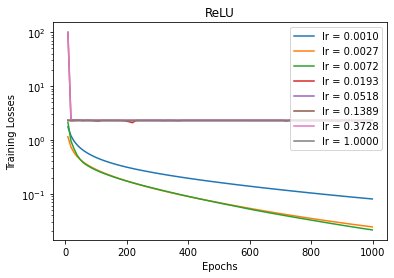

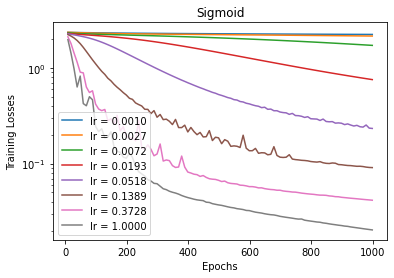

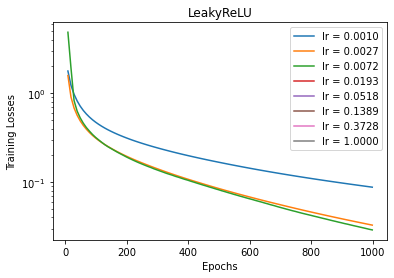

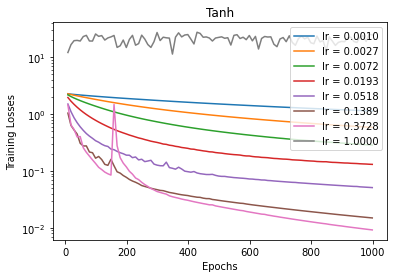

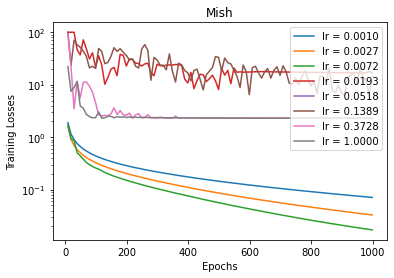

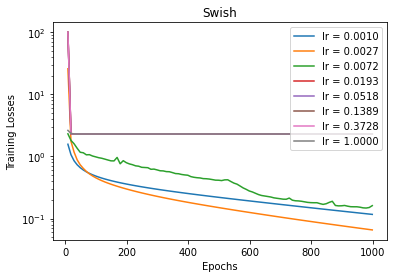

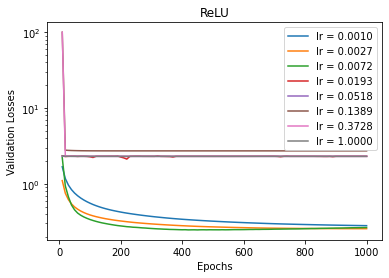

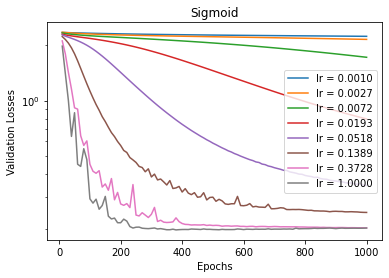

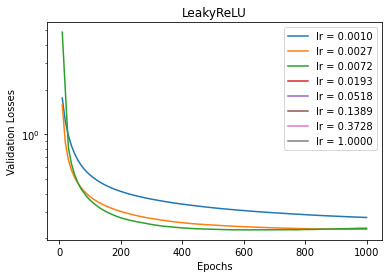

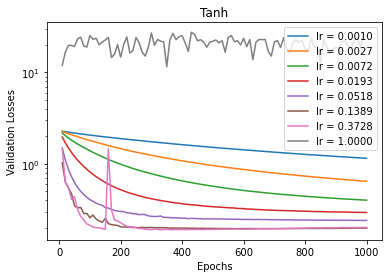

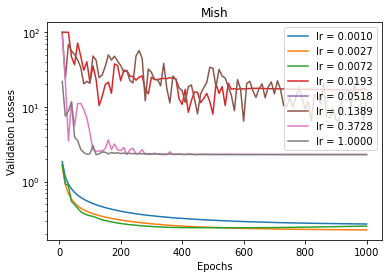

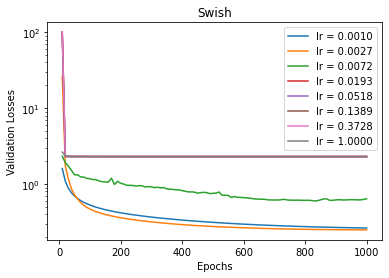

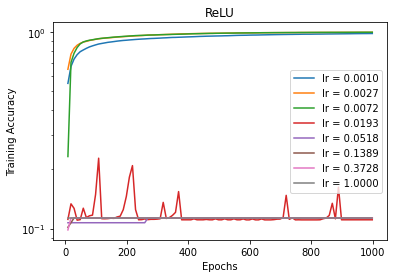

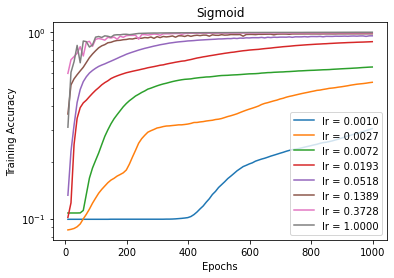

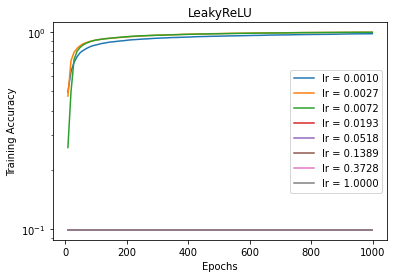

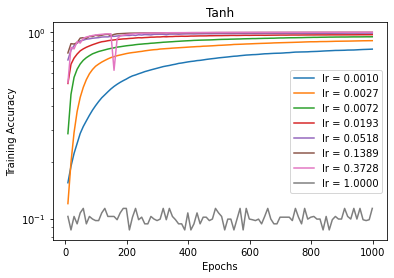

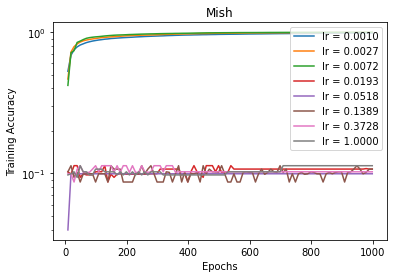

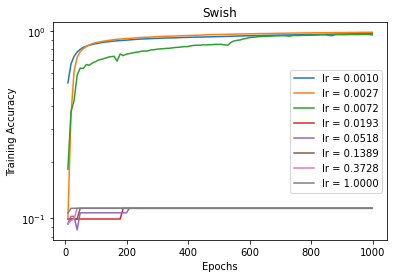

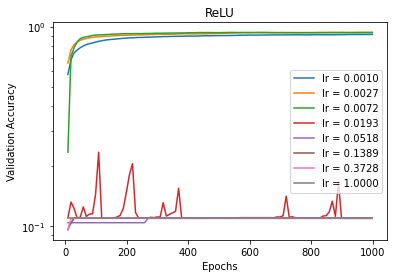

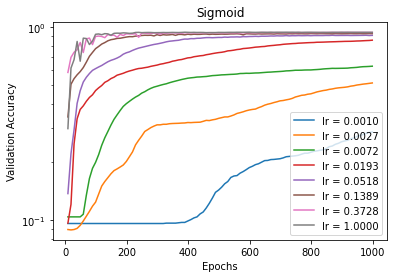

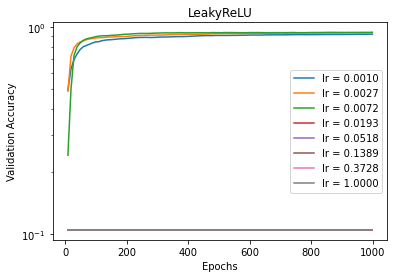

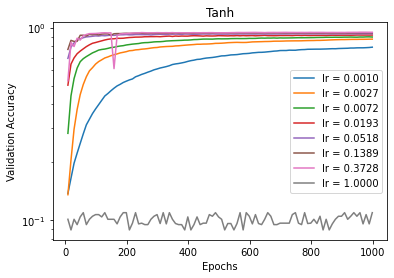

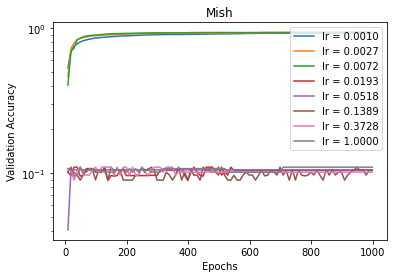

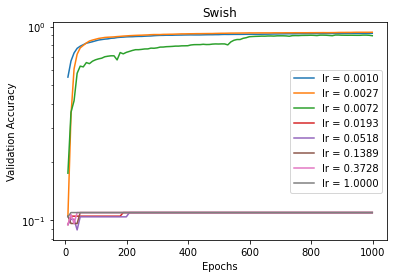

In [10]:
x_range = range(9, epochs, 10)
for i, act in enumerate(activation_units):
    for j, lr in enumerate(learning_rates[i]):
        plt.plot(x_range, np.clip(losses[i,0,j], a_min = None, a_max = 100), label = "lr = {:1.4f}".format(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Training Losses")
    #plt.ylim(0, 5)
    plt.yscale("log")
    plt.legend()
    plt.title(activation_strs[i])
    plt.show()

for i, act in enumerate(activation_units):
    for j, lr in enumerate(learning_rates[i]):
        plt.plot(x_range, np.clip(losses[i,1,j], a_min = None, a_max = 100), label = "lr = {:1.4f}".format(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Validation Losses")
    #plt.ylim(0, 5)
    plt.yscale("log")
    plt.legend()
    plt.title(activation_strs[i])
    plt.show()

for i, act in enumerate(activation_units):
    for j, lr in enumerate(learning_rates[i]):
        plt.plot(x_range, accs[i,0,j], label = "lr = {:1.4f}".format(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    #plt.ylim(0, 5)
    plt.yscale("log")
    plt.legend()
    plt.title(activation_strs[i])
    plt.show()

for i, act in enumerate(activation_units):
    for j, lr in enumerate(learning_rates[i]):
        plt.plot(x_range, accs[i,1,j], label = "lr = {:1.4f}".format(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    #plt.ylim(0, 5)
    plt.yscale("log")
    plt.legend()
    plt.title(activation_strs[i])
    plt.show()

### **(f) Training using the best learning rate**
Using the best learning rate to train on the complete training set.

Compare the loss and accuracy during training.

Then report the test accuracy for each activation. 

In [16]:
X_trainall = torch.Tensor(mnist_subsetX)
Y_trainall = torch.from_numpy(mnist_subsetY)

epochs = 1000

models = []
losses = np.zeros((len(activation_units), 2, int(epochs/10)))
accs = np.zeros((len(activation_units), 2, int(epochs/10)))
#############################################################################################################
# TODO: set the below variable "learning rate" to a list that contains the best learning rate for each activation function.
#############################################################################################################

###################################################### TODO F
learning_rate = [0.0027, 1.0, 0.0027, 0.3728, 0.0027, 0.001]
######################################################



In [17]:
for i, act in enumerate(activation_units):
    print("Training with {} activation units".format(activation_strs[i]))
    model, loss_train_his, loss_valid_his, acc_train_his, acc_valid_his = training(act, 
                200, 64, X_trainall, Y_trainall, learning_rate[i], epochs)
    models.append(model)
    losses[i,0,:] = np.array(loss_train_his)
    losses[i,1,:] = np.array(loss_valid_his)
    accs[i,0,:] = np.array(acc_train_his)
    accs[i,1,:] = np.array(acc_valid_his)

Training with ReLU activation units
9 loss =  1.347774863243103 acc =  0.5798333287239075 valid:  (1.3508386611938477, 0.5858333110809326)
19 loss =  0.8828638792037964 acc =  0.7225833535194397 valid:  (0.8641145825386047, 0.737500011920929)
29 loss =  0.6928030848503113 acc =  0.7870833277702332 valid:  (0.6746820211410522, 0.7979166507720947)
39 loss =  0.5841729640960693 acc =  0.8219166398048401 valid:  (0.5687980651855469, 0.8333333134651184)
49 loss =  0.5123171210289001 acc =  0.8460833430290222 valid:  (0.4995788633823395, 0.8537499904632568)
59 loss =  0.46017324924468994 acc =  0.862500011920929 valid:  (0.44948065280914307, 0.8679166436195374)
69 loss =  0.4207039773464203 acc =  0.875249981880188 valid:  (0.4106908142566681, 0.8824999928474426)
79 loss =  0.38909733295440674 acc =  0.8868333101272583 valid:  (0.3788470923900604, 0.8962500095367432)
89 loss =  0.36297327280044556 acc =  0.893583357334137 valid:  (0.3522892892360687, 0.9016666412353516)
99 loss =  0.34071356

769 loss =  0.058741576969623566 acc =  0.987666666507721 valid:  (0.05356944352388382, 0.9891666769981384)
779 loss =  0.05775224417448044 acc =  0.9882500171661377 valid:  (0.05271899700164795, 0.9891666769981384)
789 loss =  0.056787461042404175 acc =  0.9884166717529297 valid:  (0.051878660917282104, 0.9891666769981384)
799 loss =  0.05584710091352463 acc =  0.9889166951179504 valid:  (0.05103910341858864, 0.9895833134651184)
809 loss =  0.05492859333753586 acc =  0.9890000224113464 valid:  (0.050223518162965775, 0.9895833134651184)
819 loss =  0.05402161553502083 acc =  0.9891666769981384 valid:  (0.049412257969379425, 0.9895833134651184)
829 loss =  0.05313856899738312 acc =  0.9894999861717224 valid:  (0.0486375093460083, 0.9895833134651184)
839 loss =  0.052275508642196655 acc =  0.9895833134651184 valid:  (0.047861211001873016, 0.9900000095367432)
849 loss =  0.051429931074380875 acc =  0.9898333549499512 valid:  (0.047094639390707016, 0.9900000095367432)
859 loss =  0.0506044

519 loss =  0.04847794026136398 acc =  0.9880833625793457 valid:  (0.044159334152936935, 0.9883333444595337)
529 loss =  0.047449566423892975 acc =  0.9884166717529297 valid:  (0.043159689754247665, 0.9883333444595337)
539 loss =  0.04661339148879051 acc =  0.9884999990463257 valid:  (0.04241914302110672, 0.9887499809265137)
549 loss =  0.04622597247362137 acc =  0.9889166951179504 valid:  (0.042259059846401215, 0.9891666769981384)
559 loss =  0.0458746999502182 acc =  0.9889166951179504 valid:  (0.041992753744125366, 0.9891666769981384)
569 loss =  0.04485784471035004 acc =  0.9890833497047424 valid:  (0.041007839143276215, 0.9891666769981384)
579 loss =  0.04445654898881912 acc =  0.9891666769981384 valid:  (0.04060330614447594, 0.9895833134651184)
589 loss =  0.043588846921920776 acc =  0.9892500042915344 valid:  (0.039746370166540146, 0.9895833134651184)
599 loss =  0.0441095232963562 acc =  0.9890000224113464 valid:  (0.04034535959362984, 0.9891666769981384)
609 loss =  0.04255688

269 loss =  0.18141630291938782 acc =  0.9488333463668823 valid:  (0.17245548963546753, 0.9520833492279053)
279 loss =  0.17658701539039612 acc =  0.9505833387374878 valid:  (0.16786934435367584, 0.95291668176651)
289 loss =  0.1719936728477478 acc =  0.9515833258628845 valid:  (0.1635434478521347, 0.9541666507720947)
299 loss =  0.16761073470115662 acc =  0.953083336353302 valid:  (0.15939798951148987, 0.956250011920929)
309 loss =  0.16343678534030914 acc =  0.9549999833106995 valid:  (0.15542234480381012, 0.9574999809265137)
319 loss =  0.1594686210155487 acc =  0.956083357334137 valid:  (0.1516377329826355, 0.9579166769981384)
329 loss =  0.15566113591194153 acc =  0.9574999809265137 valid:  (0.1480201929807663, 0.9587500095367432)
339 loss =  0.15199707448482513 acc =  0.9587500095367432 valid:  (0.14454443752765656, 0.9599999785423279)
349 loss =  0.1484690010547638 acc =  0.9596666693687439 valid:  (0.14118503034114838, 0.9599999785423279)
359 loss =  0.14507430791854858 acc =  

19 loss =  0.703148603439331 acc =  0.7817500233650208 valid:  (0.6856037378311157, 0.7879166603088379)
29 loss =  0.5059219598770142 acc =  0.8551666736602783 valid:  (0.4796895384788513, 0.8704166412353516)
39 loss =  0.3476347327232361 acc =  0.9028333425521851 valid:  (0.33388060331344604, 0.909583330154419)
49 loss =  0.27175894379615784 acc =  0.9256666898727417 valid:  (0.2622392177581787, 0.9275000095367432)
59 loss =  0.24780313670635223 acc =  0.9311666488647461 valid:  (0.24023516476154327, 0.9362499713897705)
69 loss =  0.29987356066703796 acc =  0.9080833196640015 valid:  (0.29183465242385864, 0.9116666913032532)
79 loss =  0.23891720175743103 acc =  0.9298333525657654 valid:  (0.21790465712547302, 0.9366666674613953)
89 loss =  0.17457543313503265 acc =  0.953000009059906 valid:  (0.16363251209259033, 0.9541666507720947)
99 loss =  0.14787229895591736 acc =  0.9609166383743286 valid:  (0.1403540074825287, 0.9616666436195374)
109 loss =  0.13492193818092346 acc =  0.965499

769 loss =  0.010850916616618633 acc =  0.9984999895095825 valid:  (0.010835401713848114, 0.9983333349227905)
779 loss =  0.01066961046308279 acc =  0.9984999895095825 valid:  (0.010667441412806511, 0.9983333349227905)
789 loss =  0.010489333420991898 acc =  0.9985833168029785 valid:  (0.010495487600564957, 0.9983333349227905)
799 loss =  0.010317056439816952 acc =  0.9985833168029785 valid:  (0.010328231379389763, 0.9983333349227905)
809 loss =  0.010150769725441933 acc =  0.9987499713897705 valid:  (0.010172193869948387, 0.9987499713897705)
819 loss =  0.009985756129026413 acc =  0.9987499713897705 valid:  (0.010015742853283882, 0.9987499713897705)
829 loss =  0.009824511595070362 acc =  0.9987499713897705 valid:  (0.009860464371740818, 0.9987499713897705)
839 loss =  0.009665456600487232 acc =  0.9987499713897705 valid:  (0.009714539162814617, 0.9987499713897705)
849 loss =  0.009512477554380894 acc =  0.9987499713897705 valid:  (0.009565850719809532, 0.9987499713897705)
859 loss = 

519 loss =  0.08386687934398651 acc =  0.9799166917800903 valid:  (0.07469149678945541, 0.9820833206176758)
529 loss =  0.08206575363874435 acc =  0.9806666374206543 valid:  (0.07305699586868286, 0.9829166531562805)
539 loss =  0.08032165467739105 acc =  0.981083333492279 valid:  (0.0714726522564888, 0.9829166531562805)
549 loss =  0.07863103598356247 acc =  0.9816666841506958 valid:  (0.06993367522954941, 0.9837499856948853)
559 loss =  0.07699137926101685 acc =  0.9820833206176758 valid:  (0.068435899913311, 0.98416668176651)
569 loss =  0.07540028542280197 acc =  0.9829166531562805 valid:  (0.06697893142700195, 0.9850000143051147)
579 loss =  0.07385700196027756 acc =  0.9831666946411133 valid:  (0.06556487828493118, 0.9854166507720947)
589 loss =  0.07235920429229736 acc =  0.9835833311080933 valid:  (0.06419411301612854, 0.9858333468437195)
599 loss =  0.07090497016906738 acc =  0.984000027179718 valid:  (0.06286527961492538, 0.9862499833106995)
609 loss =  0.06949201226234436 acc

269 loss =  0.2837994694709778 acc =  0.9156666398048401 valid:  (0.2551320195198059, 0.9241666793823242)
279 loss =  0.278084397315979 acc =  0.9170833230018616 valid:  (0.2494397759437561, 0.9262499809265137)
289 loss =  0.27262386679649353 acc =  0.9190000295639038 valid:  (0.24401535093784332, 0.9279166460037231)
299 loss =  0.267397940158844 acc =  0.9210000038146973 valid:  (0.2388371080160141, 0.9295833110809326)
309 loss =  0.26239028573036194 acc =  0.9229166507720947 valid:  (0.23388633131980896, 0.9304166436195374)
319 loss =  0.25758296251296997 acc =  0.9244166612625122 valid:  (0.22914622724056244, 0.9316666722297668)
329 loss =  0.25296229124069214 acc =  0.9259999990463257 valid:  (0.2246013581752777, 0.9329166412353516)
339 loss =  0.24851542711257935 acc =  0.9271666407585144 valid:  (0.2202380895614624, 0.934166669845581)
349 loss =  0.2442293018102646 acc =  0.9284999966621399 valid:  (0.2160443663597107, 0.9350000023841858)
359 loss =  0.24009574949741364 acc =  0.

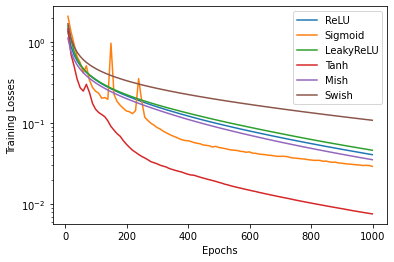

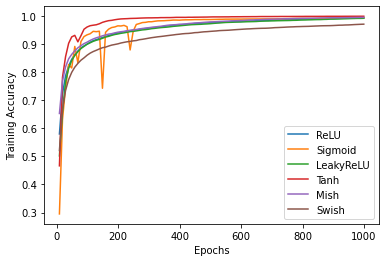

In [18]:
x_range = range(9, epochs, 10)
for i, act in enumerate(activation_units):
    plt.plot(x_range, losses[i,0], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Training Losses")
plt.yscale("log")
plt.legend()
plt.show()

for i, act in enumerate(activation_units):
    plt.plot(x_range, accs[i,0], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
#plt.yscale("log")
plt.legend()
plt.show()


In [19]:
#############################################################################################################
# TODO: Report the accuracy on test set, using the test function defined in part (d) to 
#       get the test accuracy of the model.
#       The function test returns the loss and the accuracy
#       Save the accuracy in the variable "acc"
#############################################################################################################
for i, model in enumerate(models):
    
    ###################################################### TODO
    _, acc = test(model, X_test, Y_test)
    ###################################################### TODO
    print("Accuracy of using {} activation units at learning rate {:1.4f}: {:1.4f}".format(activation_strs[i].rjust(9), learning_rate[i], acc))


Accuracy of using      ReLU activation units at learning rate 0.0027: 0.9317
Accuracy of using   Sigmoid activation units at learning rate 1.0000: 0.9410
Accuracy of using LeakyReLU activation units at learning rate 0.0027: 0.9332
Accuracy of using      Tanh activation units at learning rate 0.3728: 0.9428
Accuracy of using      Mish activation units at learning rate 0.0027: 0.9309
Accuracy of using     Swish activation units at learning rate 0.0010: 0.9223


### **(g) Visualize the learned swish activation unit**
Get the learned parameters of the swish activation unit.
Visualize the activation unit.

Fill the missing code to use matplotlib to plot the learned swish activation.
We have computed the function input x and the output y (stored in "swish_data")

In [22]:
beta1 = list(models[5].parameters())[2].data
beta2 = list(models[5].parameters())[5].data

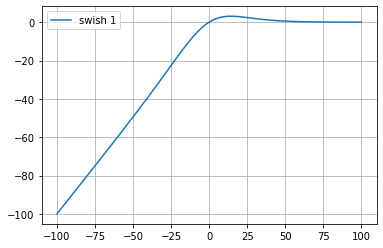

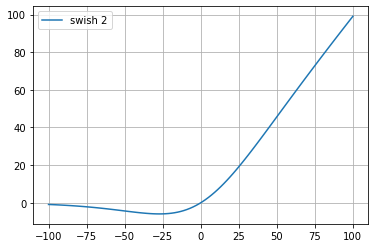

In [24]:
x = np.linspace(-100, 100, 100)

swish_data = swish(torch.Tensor(x), beta1).detach().numpy()
#############################################################################################################
# TODO: Fill the missing code to plot the swish activation function using "x" and "swish_data"
#############################################################################################################
##################################################TODO G
# plot the first swish function learned
plt.plot(x, swish_data,  label = "swish 1")
plt.legend()
plt.grid()
plt.show()
##################################################

swish_data = swish(torch.Tensor(x), beta2).detach().numpy()

##################################################TODO G
# plot the second swish function learned
plt.plot(x, swish_data,  label = "swish 2")
plt.legend()
plt.grid()
plt.show()
##################################################